## Repeater

### Prerequisites

In [ ]:
import sys
import time
from datetime import datetime, date

import numpy as np
import scipy as sp
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

import matplotlib.pyplot as plt
import seaborn as sns

import torch

from utils import (
    Repeater,
    Generator,
    Evaluator,
    device,
)

cpu


### MIMO 5x2

#### Data

In [23]:
A = np.array([[0, 1, 0, 0, 0],
              [-1, -0.5, 0, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, -1, -0.5, 0],
              [0, 0, 0, 0, -1]])

B = np.array([[1, 0, 0, 0, 0],
              [0, 1, 0, 0, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 0, 0, 1]])

C = np.array([[1, 0, 0, 0, 0],
              [0, 1, 0, 0, 0]])

D = np.zeros((2, 5))

sys = sp.signal.StateSpace(A, B, C, D)

input_size = np.array(D).shape[1]
output_size = np.array(D).shape[0]

signal_length = 60*24*30
sf = 8
t = np.arange(0, signal_length/sf, 1/sf)

params = {
    "period": len(t),
    "initial_value": 0,
    "setpoint_min": 0,
    "setpoint_max": 1e1,
    "setpoint_step": 1e-1,
    "duration_min": 5e1,
    "duration_max": 2e2,
}

In [24]:
generator = Generator()

x = []
for i in range(input_size):
    x.append(generator.generate_prbs(**params))
x = np.transpose(x)

_, y, _ = sp.signal.lsim(sys, x, t)

batch_size = 2**5
lag = 2**3

train_dataloader, val_dataloader = generator.generate_dataloaders(x, y, lag, batch_size)

In [25]:
columns = []
for i in range(input_size + output_size):
    columns.append("sensor_" + generator.generate_key())

input_columns = columns[:input_size]
output_columns = columns[input_size:]

data = np.concatenate((x, y), axis=1)
df = pd.DataFrame(data=data)
df.columns = columns
df.index = pd.to_datetime(pd.date_range(start=date.today(), periods=df.shape[0], freq="min").strftime("%Y-%m-%d %H:%M:%S.%f"))
df.index.name = "date_time"

df.to_csv("./datasets/mimo_5x2_dataset.csv")

<Axes: >

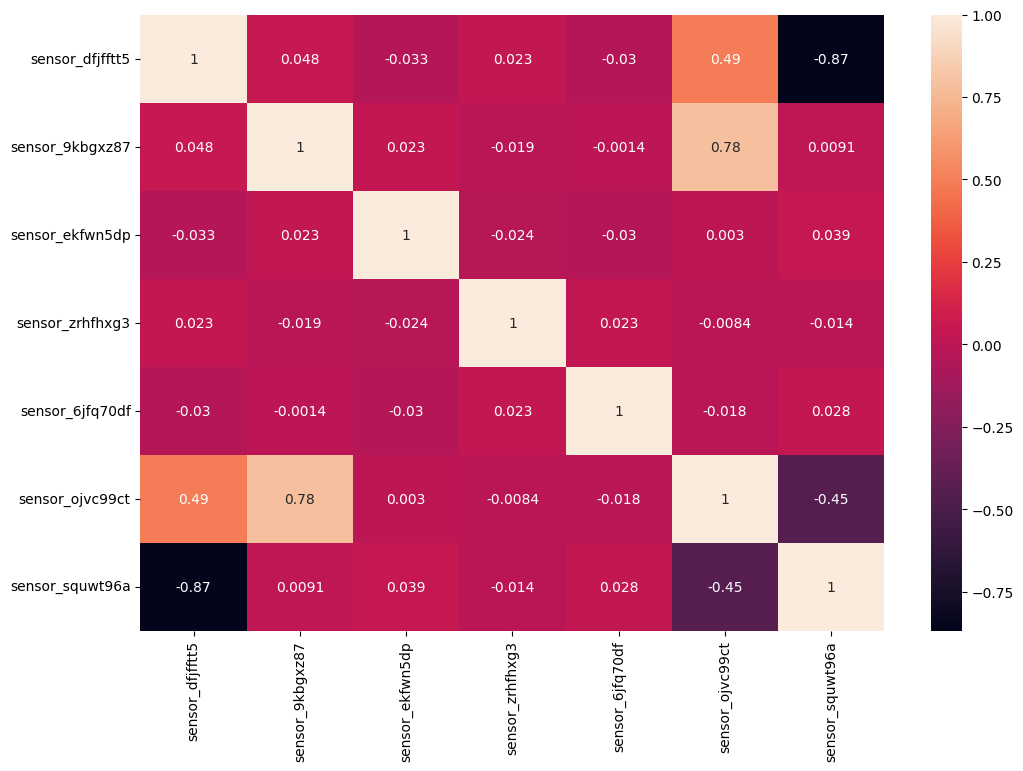

In [26]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(method="pearson"), annot=True)

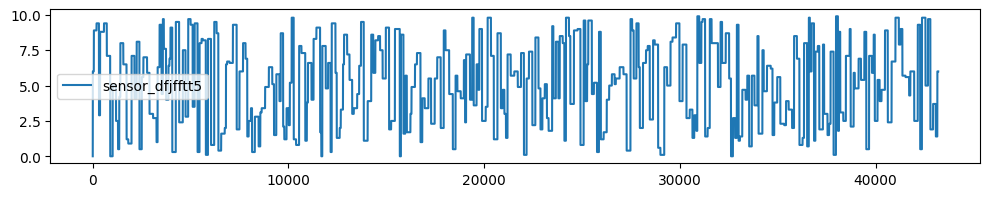

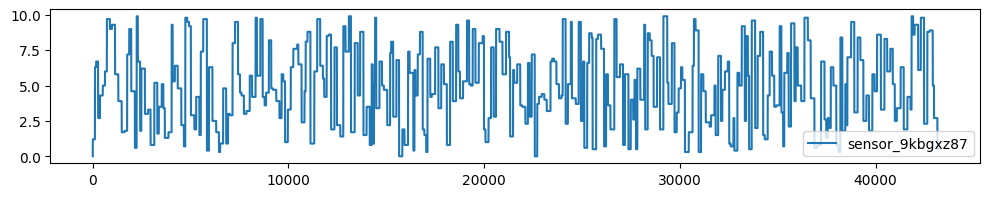

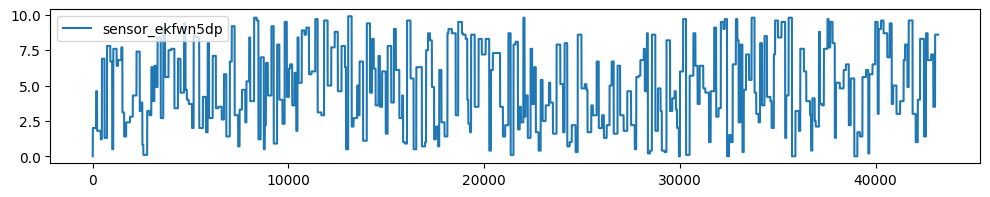

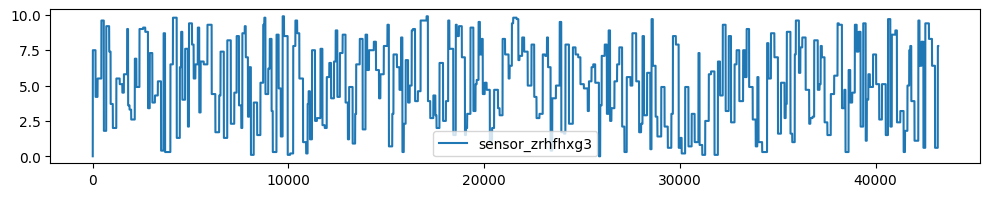

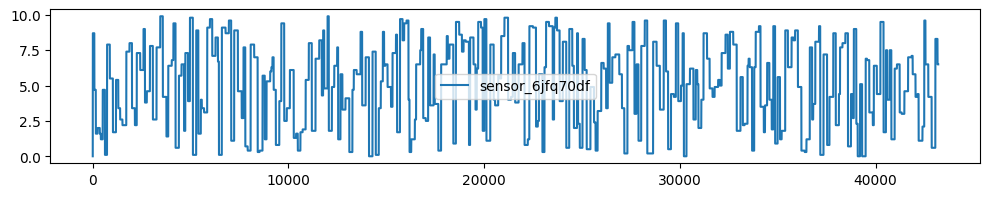

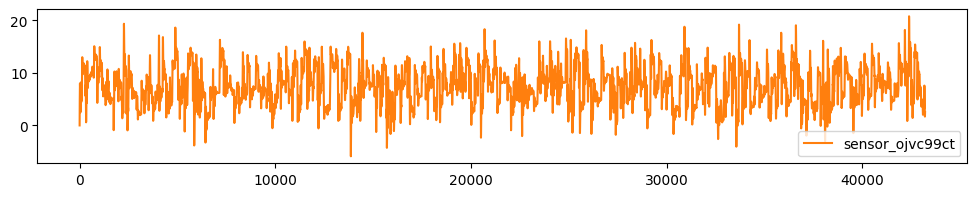

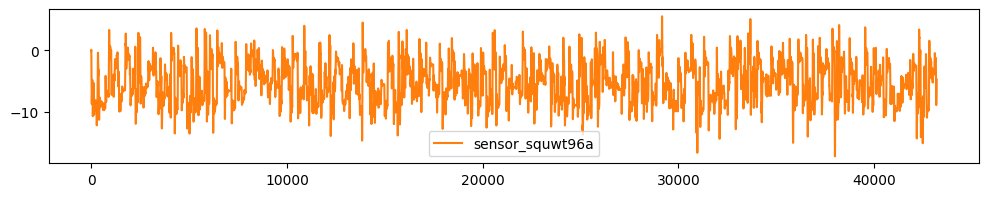

In [27]:
for i in range(x.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(x[:, i], label=input_columns[i])
    plt.legend()
    plt.show()

for i in range(y.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(y[:, i], label=output_columns[i], color="tab:orange")
    plt.legend()
    plt.show()

#### Model

In [28]:
config = {
    "input_size": input_size + output_size,
    "output_size": output_size,
    "hidden_size": 2**5,
    "num_layers": 2**1,
    "learning_rate": 1e-3,
    "dropout": 0,
    "lag": lag,
    "epochs": 2**5,
}

In [29]:
repeater = Repeater(**config).to(device)
print(repeater)

Repeater(
  (lstm): LSTM(7, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=2, bias=True)
  (loss_fn): MSELoss()
)


#### Train

In [30]:
%%time
repeater.fit(train_dataloader, val_dataloader)

Epoch 1/32
675/675 [====================================================================================================] 100%
0.0035s 0.0035s/step - train_loss: 0.00436071 - val_loss: 0.00015033 

Epoch 2/32
675/675 [====================================================================================================] 100%
0.0058s 0.0029s/step - train_loss: 0.00221565 - val_loss: 0.00010228 

Epoch 3/32
675/675 [====================================================================================================] 100%
0.0083s 0.0028s/step - train_loss: 0.00148706 - val_loss: 0.00007963 

Epoch 4/32
675/675 [====================================================================================================] 100%
0.0100s 0.0025s/step - train_loss: 0.00112104 - val_loss: 0.00006516 

Epoch 5/32
675/675 [====================================================================================================] 100%
0.0113s 0.0023s/step - train_loss: 0.00090063 - val_loss: 0.00005474 

Epoch 6/32

In [32]:
repeater.data_min = generator.y_scaler.data_min_.tolist()
repeater.data_max = generator.y_scaler.data_max_.tolist()

model_path = './models/repeater_5x2.pt'
# torch.save(repeater.state_dict(), model_path)
torch.jit.script(repeater).save(model_path)

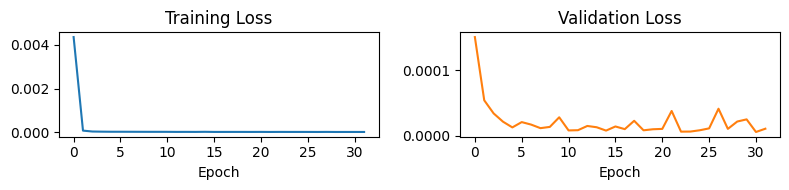

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].plot(repeater.train_loss)
axs[0].set_title('Training Loss')
axs[1].plot(repeater.val_loss, color='tab:orange')
axs[1].set_title('Validation Loss')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='')

fig.tight_layout()

#### Test

In [34]:
for parameter in repeater.parameters():
  parameter.requires_grad = False
repeater.eval()

# repeater = torch.jit.load(model_path)
# repeater.eval()

Repeater(
  (lstm): LSTM(7, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=2, bias=True)
  (loss_fn): MSELoss()
)

In [35]:
# y_test_scaled = repeater.forward(generator.x_test)
y_test_scaled = repeater.test(generator.x_test, (generator.x_val, generator.y_val))
y_test = generator.y_scaler.inverse_transform(y_test_scaled)

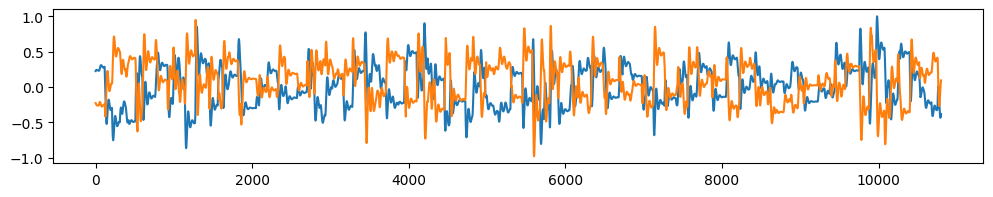

In [36]:
plt.figure(figsize=(12, 2))
plt.plot(repeater.y_tick)

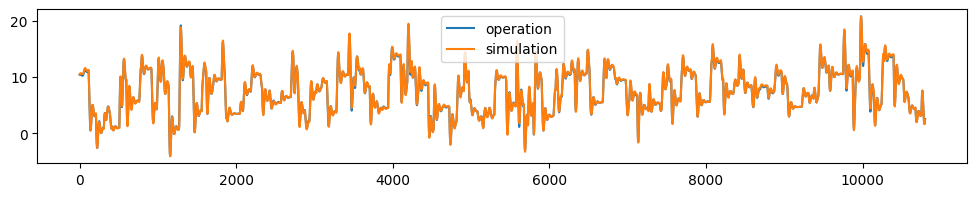

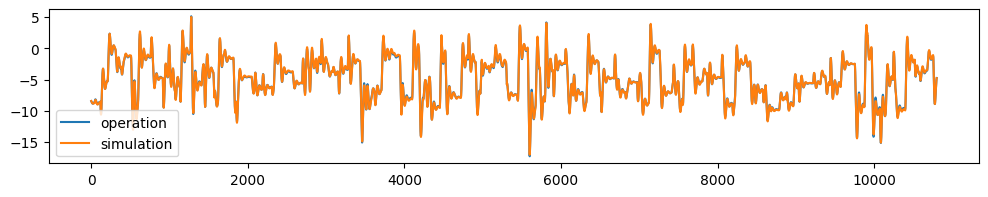

In [37]:
for i in range(y.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(generator.y_scaler.inverse_transform(generator.y_test)[:, i], label='operation')
    plt.plot(y_test[:, i], label='simulation')
    plt.legend()
    plt.show()

#### Evaluate

In [38]:
evaluator = Evaluator()

for i in range(output_size):
    metrics_dict = evaluator.measure(generator.y_scaler.inverse_transform(generator.y_test)[:, i], y_test[:, i])
    print(metrics_dict)

{'explained_variance_score': 0.9981741214031997, 'mean_absolute_error': 0.11879137871050112, 'mean_squared_error': 0.027874385540102114, 'root_mean_squared_error': np.float64(0.16695623839827642), 'median_absolute_error': 0.08603901820135196, 'mean_absolute_percentage_error': 0.035553879226305485, 'd2_absolute_error_score': 0.9619218022293474, 'd2_pinball_score': 0.9619218022293474, 'r2_score': 0.9979991056815184}
{'explained_variance_score': 0.9980078127449951, 'mean_absolute_error': 0.1101377268273714, 'mean_squared_error': 0.020784813846519826, 'root_mean_squared_error': np.float64(0.14416939289086234), 'median_absolute_error': 0.08845543389918675, 'mean_absolute_percentage_error': 0.15931980816601257, 'd2_absolute_error_score': 0.9585699822349552, 'd2_pinball_score': 0.9585699822349552, 'r2_score': 0.9979908988632434}


In [39]:
evaluator = Evaluator()
metrics_dict = evaluator.measure(generator.y_scaler.inverse_transform(generator.y_test), y_test)
metrics_dict

{'explained_variance_score': 0.9980909670740974,
 'mean_absolute_error': 0.1144645527689361,
 'mean_squared_error': 0.02432959969331098,
 'root_mean_squared_error': np.float64(0.1559794848475625),
 'median_absolute_error': 0.08724722605026936,
 'mean_absolute_percentage_error': 0.09743684369615879,
 'd2_absolute_error_score': 0.9602458922321513,
 'd2_pinball_score': 0.9602458922321513,
 'r2_score': 0.9979950022723809}

In [40]:
while True:
    time.sleep(1)
    pass

KeyboardInterrupt: 

### Zyfra

#### Data

In [ ]:
df = pd.read_csv('./datasets/zyfra/zyfra_dataset.csv', parse_dates=["date"], infer_datetime_format=True).set_index('date').astype(float)
# df.index = pd.to_datetime(df.index)
df.index = pd.to_datetime(pd.date_range(start=df.index[0], periods=df.shape[0], freq="h").strftime("%Y-%m-%d %H:%M:%S.%f"))
df = df.resample("h").interpolate(method="linear", limit_direction="both", axis=0)
df.index.name = "date_time"
df.interpolate(method="linear", limit_direction="both", axis=0)
df.fillna(method='ffill', axis=0, inplace=True)
df = df.applymap(lambda x: -x if x < 0 else x)

print(df.shape)

(22716, 86)


In [ ]:
# Z-score
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3471 entries, 2016-01-29 19:00:00 to 2018-07-31 14:00:00
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         3471 non-null   float64
 1   final.output.concentrate_pb                         3471 non-null   float64
 2   final.output.concentrate_sol                        3471 non-null   float64
 3   final.output.concentrate_au                         3471 non-null   float64
 4   final.output.recovery                               3471 non-null   float64
 5   final.output.tail_ag                                3471 non-null   float64
 6   final.output.tail_pb                                3471 non-null   float64
 7   final.output.tail_sol                               3471 non-null   float64
 8   final.output.tail_au                      

In [ ]:
df.head()

final.output.concentrate_ag  final.output.concentrate_pb  \
date_time                                                                       
2016-01-29 19:00:00                     6.216028                    10.491338   
2016-01-29 20:00:00                     7.439060                     9.674481   
2016-01-30 14:00:00                     5.958196                    11.547179   
2016-02-03 21:00:00                     6.124834                     9.189736   
2016-02-04 01:00:00                     6.200552                     7.895123   

                     final.output.concentrate_sol  \
date_time                                           
2016-01-29 19:00:00                      7.720797   
2016-01-29 20:00:00                      7.721502   
2016-01-30 14:00:00                      7.215985   
2016-02-03 21:00:00                      2.234204   
2016-02-04 01:00:00                      2.630558   

                     final.output.concentrate_au  final.output.recovery  \
date_time                                                                 
2016-01-29 19:00:00                    42.600851              72.878517   
2016-01-29 20:00:00                    40.859356              65.944912   
2016-01-30 14:00:00                    41.843601              76.435094   
2016-02-03 21:00:00                    43.667700              64.086801   
2016-02-04 01:00:00                    45.194430              52.963336   

                     final.output.tail_ag  final.output.tail_pb  \
date_time                                                         
2016-01-29 19:00:00             11.702119              1.205711   
2016-01-29 20:00:00             12.271132              1.405582   
2016-01-30 14:00:00             11.097235              1.074875   
2016-02-03 21:00:00             12.079331              2.262333   
2016-02-04 01:00:00             11.447746              2.195933   

                     final.output.tail_sol  final.output.tail_au  \
date_time                                                          
2016-01-29 19:00:00               8.275870              2.476420   
2016-01-29 20:00:00               4.790456              2.804975   
2016-01-30 14:00:00              17.229048              2.374459   
2016-02-03 21:00:00              11.399560              3.065930   
2016-02-04 01:00:00              13.481369              3.444854   

                     primary_cleaner.input.sulfate  ...  \
date_time                                           ...   
2016-01-29 19:00:00                      85.938251  ...   
2016-01-29 20:00:00                      61.813362  ...   
2016-01-30 14:00:00                     172.439903  ...   
2016-02-03 21:00:00                     150.002714  ...   
2016-02-04 01:00:00                     117.267682  ...   

                     secondary_cleaner.state.floatbank4_a_air  \
date_time                                                       
2016-01-29 19:00:00                                 13.623560   
2016-01-29 20:00:00                                 12.992534   
2016-01-30 14:00:00                                 15.006878   
2016-02-03 21:00:00                                 17.014247   
2016-02-04 01:00:00                                 16.994768   

                     secondary_cleaner.state.floatbank4_a_level  \
date_time                                                         
2016-01-29 19:00:00                                  499.432242   
2016-01-29 20:00:00                                  498.622660   
2016-01-30 14:00:00                                  499.804568   
2016-02-03 21:00:00                                  504.222281   
2016-02-04 01:00:00                                  502.415746   

                     secondary_cleaner.state.floatbank4_b_air  \
date_time                                                       
2016-01-29 19:00:00                                 13.083908   
2016-01-29 20:00:00                                 13.047256   
2016-01-

In [ ]:
# feed_rate (t/h)
# feed_size (um)
# feed_au (%)
# concentrate (%)
# air (Nm³/h)
# level (m)
# reagents (g/t)

columns = [
    # 'final.output.concentrate_ag',
    # 'final.output.concentrate_pb',
    # 'final.output.concentrate_sol',
    # 'final.output.concentrate_au',
    # 'final.output.recovery',
    # 'final.output.tail_ag',
    # 'final.output.tail_pb',
    # 'final.output.tail_sol',
    # 'final.output.tail_au',
    # 'primary_cleaner.input.sulfate',
    # 'primary_cleaner.input.depressant',
    # 'primary_cleaner.input.feed_size',
    # 'primary_cleaner.input.xanthate',
    # 'primary_cleaner.output.concentrate_ag',
    # 'primary_cleaner.output.concentrate_pb',
    # 'primary_cleaner.output.concentrate_sol',
    # 'primary_cleaner.output.concentrate_au',
    # 'primary_cleaner.output.tail_ag',
    # 'primary_cleaner.output.tail_pb',
    # 'primary_cleaner.output.tail_sol',
    # 'primary_cleaner.output.tail_au',
    # 'primary_cleaner.state.floatbank8_a_air',
    # 'primary_cleaner.state.floatbank8_a_level',
    # 'primary_cleaner.state.floatbank8_b_air',
    # 'primary_cleaner.state.floatbank8_b_level',
    # 'primary_cleaner.state.floatbank8_c_air',
    # 'primary_cleaner.state.floatbank8_c_level',
    # 'primary_cleaner.state.floatbank8_d_air',
    # 'primary_cleaner.state.floatbank8_d_level',
    # 'rougher.calculation.sulfate_to_au_concentrate',
    # 'rougher.calculation.floatbank10_sulfate_to_au_feed',
    # 'rougher.calculation.floatbank11_sulfate_to_au_feed',
    # 'rougher.calculation.au_pb_ratio',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'rougher.input.feed_sol',
    'rougher.input.feed_au',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank10_xanthate',
    # 'rougher.input.floatbank11_sulfate',
    # 'rougher.input.floatbank11_xanthate',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol',
    'rougher.output.concentrate_au',
    # 'rougher.output.recovery',
    'rougher.output.tail_ag',
    'rougher.output.tail_pb',
    'rougher.output.tail_sol',
    'rougher.output.tail_au',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    # 'rougher.state.floatbank10_c_air',
    # 'rougher.state.floatbank10_c_level',
    # 'rougher.state.floatbank10_d_air',
    # 'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    # 'rougher.state.floatbank10_e_level',
    # 'rougher.state.floatbank10_f_air',
    # 'rougher.state.floatbank10_f_level',
    # 'secondary_cleaner.output.tail_ag',
    # 'secondary_cleaner.output.tail_pb',
    # 'secondary_cleaner.output.tail_sol',
    # 'secondary_cleaner.output.tail_au',
    # 'secondary_cleaner.state.floatbank2_a_air',
    # 'secondary_cleaner.state.floatbank2_a_level',
    # 'secondary_cleaner.state.floatbank2_b_air',
    # 'secondary_cleaner.state.floatbank2_b_level',
    # 'secondary_cleaner.state.floatbank3_a_air',
    # 'secondary_cleaner.state.floatbank3_a_level',
    # 'secondary_cleaner.state.floatbank3_b_air',
    # 'secondary_cleaner.state.floatbank3_b_level',
    # 'secondary_cleaner.state.floatbank4_a_air',
    # 'secondary_cleaner.state.floatbank4_a_level',
    # 'secondary_cleaner.state.floatbank4_b_air',
    # 'secondary_cleaner.state.floatbank4_b_level',
    # 'secondary_cleaner.state.floatbank5_a_air',
    # 'secondary_cleaner.state.floatbank5_a_level',
    # 'secondary_cleaner.state.floatbank5_b_air',
    # 'secondary_cleaner.state.floatbank5_b_level',
    # 'secondary_cleaner.state.floatbank6_a_air',
    # 'secondary_cleaner.state.floatbank6_a_level'
 ]

input_columns = [
    # 'rougher.input.feed_ag',
    # 'rougher.input.feed_pb',
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    # 'rougher.input.feed_sol',
    # 'rougher.input.feed_au',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank10_xanthate',
    # 'rougher.input.floatbank11_sulfate',
    # 'rougher.input.floatbank11_xanthate',
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air',
    'rougher.state.floatbank10_b_level',
    # 'rougher.state.floatbank10_c_air',
    # 'rougher.state.floatbank10_c_level',
    # 'rougher.state.floatbank10_d_air',
    # 'rougher.state.floatbank10_d_level',
    'rougher.state.floatbank10_e_air',
    # 'rougher.state.floatbank10_e_level',
    # 'rougher.state.floatbank10_f_air',
    # 'rougher.state.floatbank10_f_level',
]

output_columns = [
    'rougher.output.concentrate_ag',
    # 'rougher.output.concentrate_pb',
    # 'rougher.output.concentrate_sol',
    # 'rougher.output.concentrate_au',
    # 'rougher.output.tail_ag',
    # 'rougher.output.tail_pb',
    # 'rougher.output.tail_sol',
    # 'rougher.output.tail_au',
]

threshold = 0.1
selector = VarianceThreshold(threshold=threshold)
df_selected = pd.DataFrame(selector.fit_transform(df[input_columns]), columns=df[input_columns].columns[selector.get_support()])
input_columns = list(df_selected.columns.values)

df = df[columns]
df[input_columns + output_columns].to_csv("./datasets/zyfra_flotation.csv")

<AxesSubplot: >

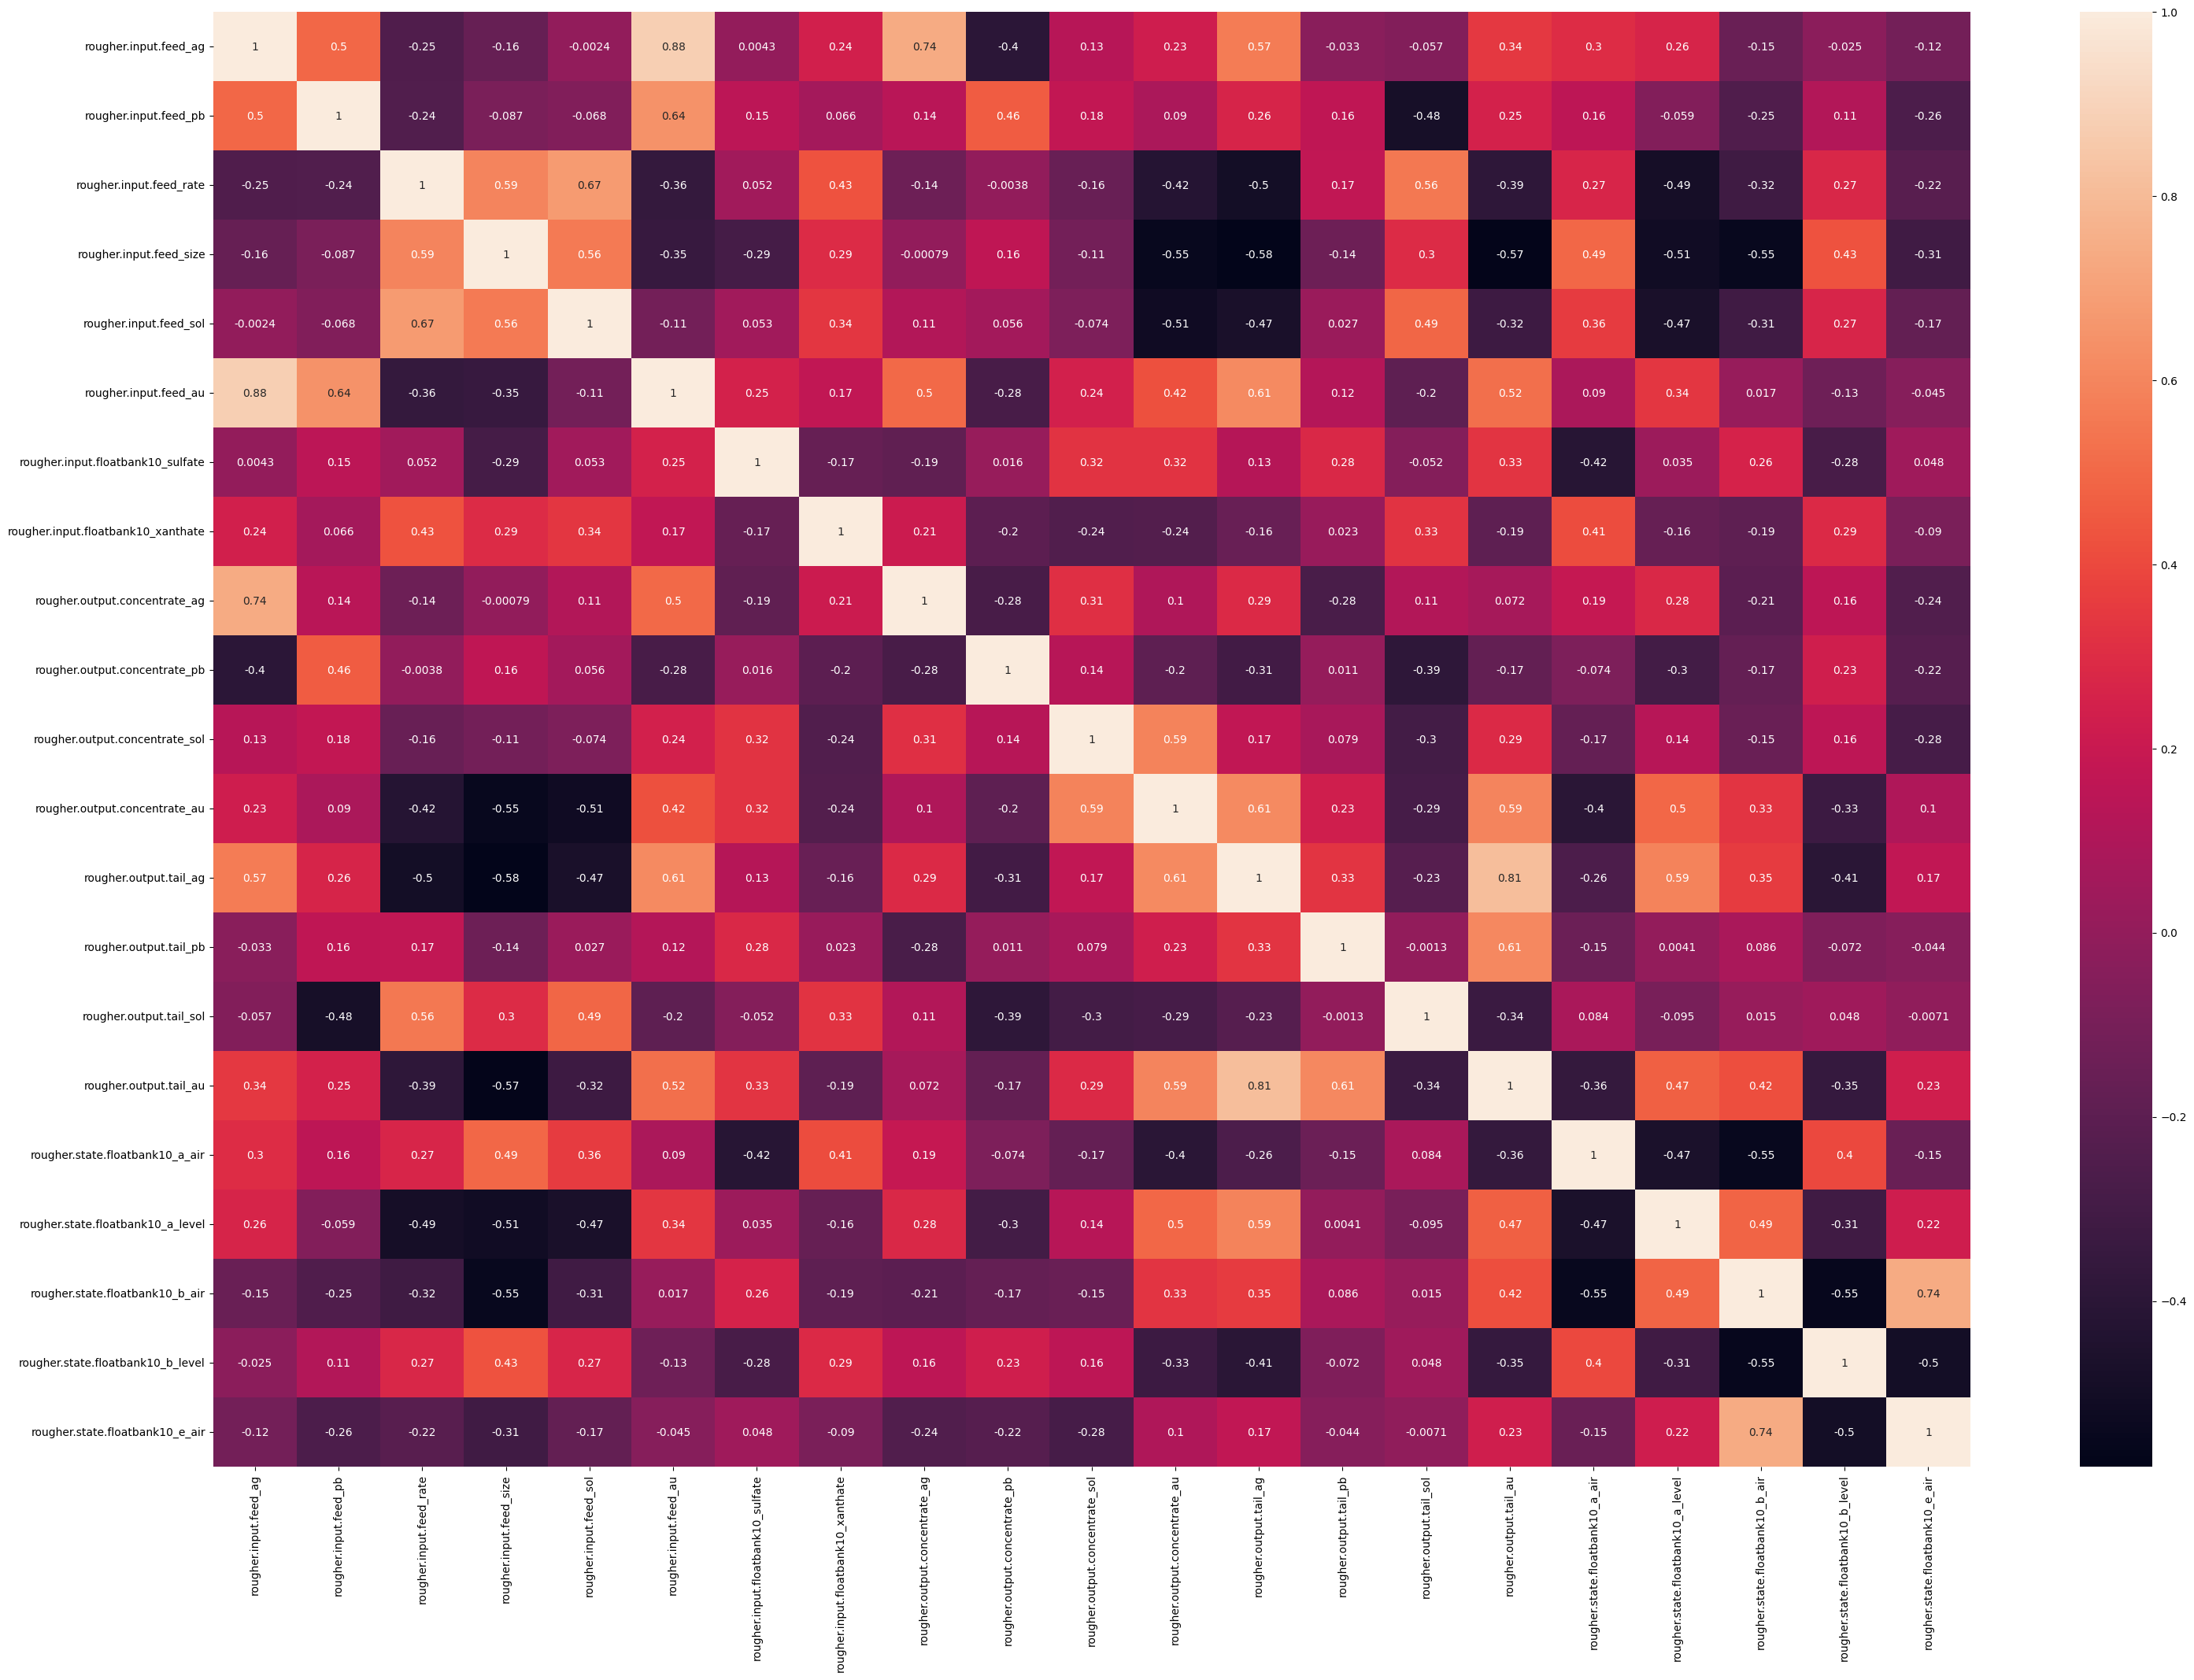

In [ ]:
df_corr = df.corr(method="pearson")

plt.figure(figsize=(36, 24))
sns.heatmap(df_corr, annot=True)

In [ ]:
# df_corr[output_columns][df_corr[output_columns].abs() >= 0.2]
df_corr[input_columns][df_corr[input_columns] >= 0.8]

rougher.input.feed_rate  \
rougher.input.feed_ag                                   NaN   
rougher.input.feed_pb                                   NaN   
rougher.input.feed_rate                                 1.0   
rougher.input.feed_size                                 NaN   
rougher.input.feed_sol                                  NaN   
rougher.input.feed_au                                   NaN   
rougher.input.floatbank10_sulfate                       NaN   
rougher.input.floatbank10_xanthate                      NaN   
rougher.output.concentrate_ag                           NaN   
rougher.output.concentrate_pb                           NaN   
rougher.output.concentrate_sol                          NaN   
rougher.output.concentrate_au                           NaN   
rougher.output.tail_ag                                  NaN   
rougher.output.tail_pb                                  NaN   
rougher.output.tail_sol                                 NaN   
rougher.output.tail_au                                  NaN   
rougher.state.floatbank10_a_air                         NaN   
rougher.state.floatbank10_a_level                       NaN   
rougher.state.floatbank10_b_air                         NaN   
rougher.state.floatbank10_b_level                       NaN   
rougher.state.floatbank10_e_air                         NaN   

                                    rougher.input.feed_size  \
rougher.input.feed_ag                                   NaN   
rougher.input.feed_pb                                   NaN   
rougher.input.feed_rate                                 NaN   
rougher.input.feed_size                                 1.0   
rougher.input.feed_sol                                  NaN   
rougher.input.feed_au                                   NaN   
rougher.input.floatbank10_sulfate                       NaN   
rougher.input.floatbank10_xanthate                      NaN   
rougher.output.concentrate_ag                           NaN   
rougher.output.concentrate_pb                           NaN   
rougher.output.concentrate_sol                          NaN   
rougher.output.concentrate_au                           NaN   
rougher.output.tail_ag                                  NaN   
rougher.output.tail_pb                                  NaN   
rougher.output.tail_sol                                 NaN   
rougher.output.tail_au                                  NaN   
rougher.state.floatbank10_a_air                         NaN   
rougher.state.floatbank10_a_level                       NaN   
rougher.state.floatbank10_b_air                         NaN   
rougher.state.floatbank10_b_level                       NaN   
rougher.state.floatbank10_e_air                         NaN   

                                    rougher.input.floatbank10_sulfate  \
rougher.input.feed_ag                                             NaN   
rougher.input.feed_pb                                             NaN   
rougher.input.feed_rate                                           NaN   
rougher.input.feed_size                                           NaN   
rougher.input.feed_sol                                            NaN   
rougher.input.feed_au                                             NaN   
rougher.input.floatbank10_sulfate                                 1.0   
rougher.input.floatbank10_xanthate                                NaN   
rougher.output.concentrate_ag                                     NaN   
rougher.output.concentrate_pb                                     NaN   
rougher.output.concentrate_sol                                    NaN   
rougher.output.concentrate_au                                     NaN   
rougher.output.tail_ag                                            NaN   
rougher.output.tail_pb                                            NaN   
rougher.output.tail_sol                                           NaN   
rougher.output.tail_au                                            NaN   
rougher.state.floatba

In [ ]:
input_size = len(input_columns)
output_size = len(output_columns)

x = df[input_columns].values
y = df[output_columns].values

In [ ]:
df[input_columns].describe()

rougher.input.feed_rate  rougher.input.feed_size  \
count              3471.000000              3471.000000   
mean                503.011965                57.810751   
std                  75.358772                13.317967   
min                 175.365999                21.345670   
25%                 450.561517                46.696826   
50%                 510.242866                54.844849   
75%                 558.177783                67.925769   
max                 697.914084                90.420232   

       rougher.input.floatbank10_sulfate  rougher.input.floatbank10_xanthate  \
count                        3471.000000                         3471.000000   
mean                           12.239093                            6.378400   
std                             2.907692                            0.813650   
min                             3.263654                            3.260339   
25%                            10.001154                            5.992098   
50%                            12.000040                            6.402163   
75%                            14.732392                            6.936372   
max                            20.005140                            8.919601   

       rougher.state.floatbank10_a_air  rougher.state.floatbank10_a_level  \
count                      3471.000000                        3471.000000   
mean                       1112.257590                         358.871310   
std                         165.964668                          86.989593   
min                         685.945050                         293.920129   
25%                         999.529965                         299.949960   
50%                        1001.266298                         300.151319   
75%                        1202.895579                         499.525443   
max                        1411.527154                         504.408914   

       rougher.state.floatbank10_b_air  rougher.state.floatbank10_b_level  \
count                      3471.000000                        3471.000000   
mean                       1290.266084                         476.170671   
std                         152.874819                          42.234034   
min                         992.326256                         394.655415   
25%                        1198.907202                         498.080770   
50%                        1299.367044                         499.862599   
75%                        1400.291878                         500.247582   
max                        1606.231421                         508.120124   

       rougher.state.floatbank10_e_air  
count                      3471.000000  
mean                       1059.650841  
std                         154.421615  
min                         596.697406  
25%                         997.306550  
50%                        1049.697243  
75%                        1103.949904  
max                        1566.967833

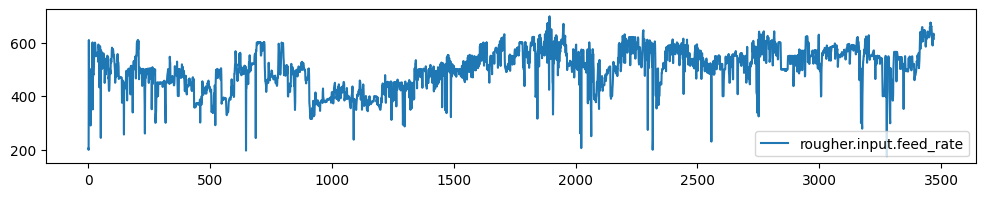

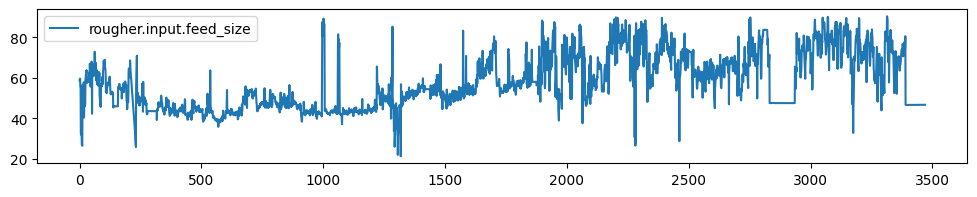

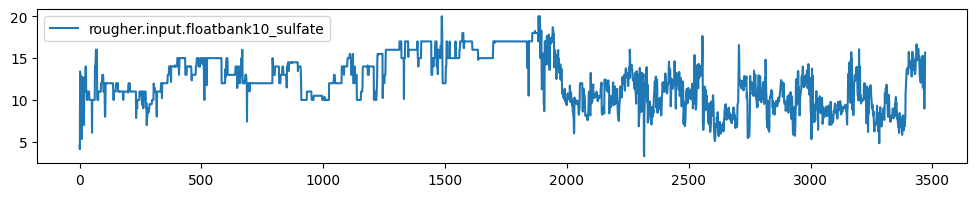

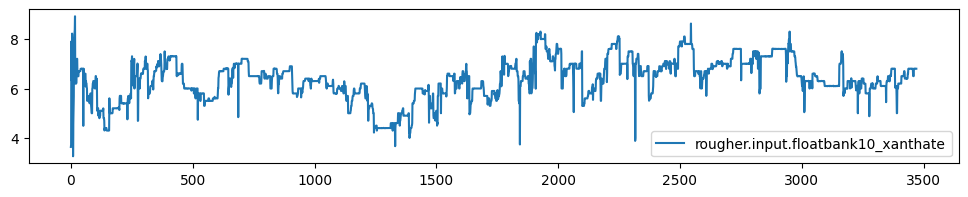

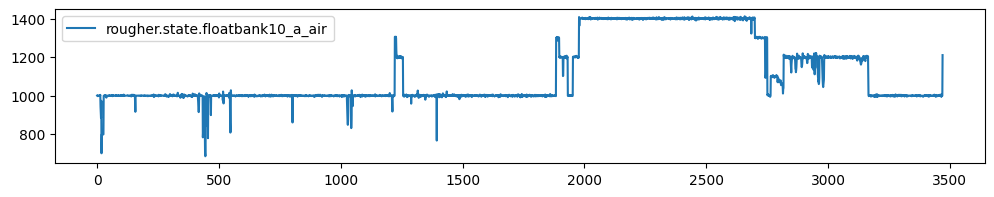

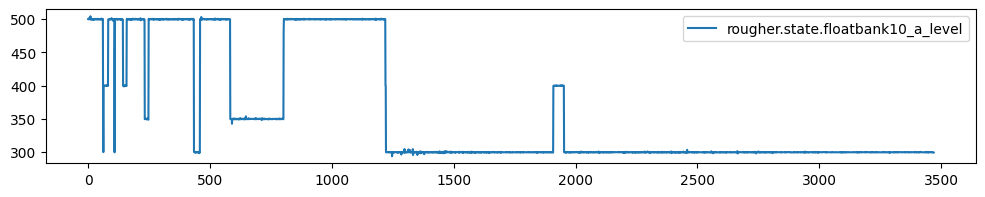

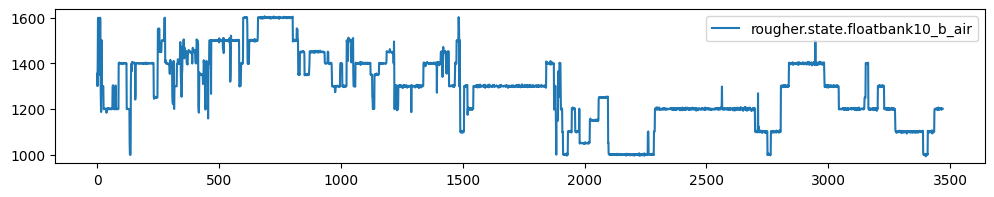

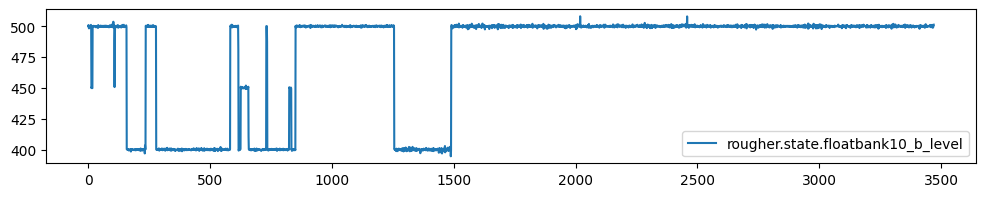

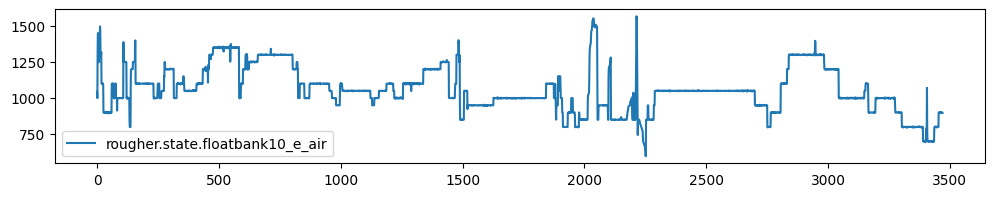

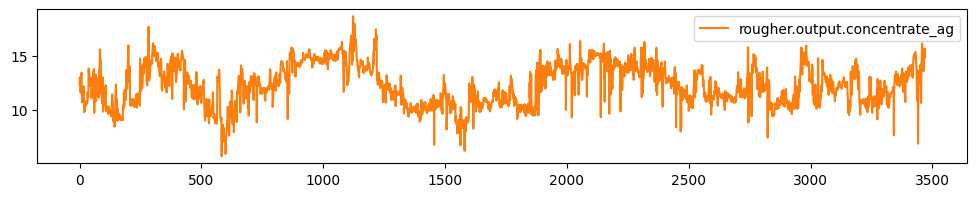

In [ ]:
for i in range(x.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(x[:, i], label=input_columns[i])
    plt.legend()
    plt.show()

for i in range(y.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(y[:, i], label=output_columns[i], color="tab:orange")
    plt.legend()
    plt.show()

In [ ]:
batch_size = 2**5
lag = 2**5

generator = Generator()
train_dataloader, val_dataloader = generator.generate_dataloaders(x, y, lag, batch_size)

#### Model

In [ ]:
config = {
    "input_size": input_size + output_size,
    "output_size": output_size,
    "hidden_size": 2**5,
    "num_layers": 2**1,
    "learning_rate": 1e-3,
    "dropout": 0,
    "lag": lag,
    "epochs": 2**5
}

In [ ]:
repeater = Repeater(**config).to(device)
print(repeater)

Repeater(
  (lstm): LSTM(10, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
  (loss_fn): MSELoss()
)


#### Train

In [ ]:
%%time
repeater.fit(train_dataloader, val_dataloader)

Epoch 1/32
54/54 [====================================================================================================] 100%
0.0020s 0.0020s/step - train_loss: 0.07705617 - val_loss: 0.11030369 

Epoch 2/32
54/54 [====================================================================================================] 100%
0.0039s 0.0020s/step - train_loss: 0.05194228 - val_loss: 0.07771217 

Epoch 3/32
54/54 [====================================================================================================] 100%
0.0061s 0.0020s/step - train_loss: 0.04171453 - val_loss: 0.06270693 

Epoch 4/32
54/54 [====================================================================================================] 100%
0.0084s 0.0021s/step - train_loss: 0.03610959 - val_loss: 0.05516529 

Epoch 5/32
54/54 [====================================================================================================] 100%
0.0102s 0.0020s/step - train_loss: 0.03251938 - val_loss: 0.05014797 

Epoch 6/32
54/54 [==

In [ ]:
model_path = './models/repeater_zyfra_flotation.pt'
torch.save(repeater.state_dict(), model_path)

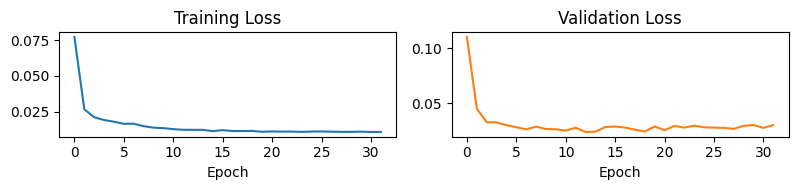

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].plot(repeater.train_loss)
axs[0].set_title('Training Loss')
axs[1].plot(repeater.val_loss, color='tab:orange')
axs[1].set_title('Validation Loss')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='')

fig.tight_layout()

#### Test

In [ ]:
for parameter in repeater.parameters():
  parameter.requires_grad = False
repeater.eval()

Repeater(
  (lstm): LSTM(10, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
  (loss_fn): MSELoss()
)

In [ ]:
# y_test_scaled = repeater.test(generator.x_test, (generator.x_val, generator.y_val))
y_test_scaled = repeater.test(generator.x_test)
y_test = generator.y_scaler.inverse_transform(y_test_scaled)

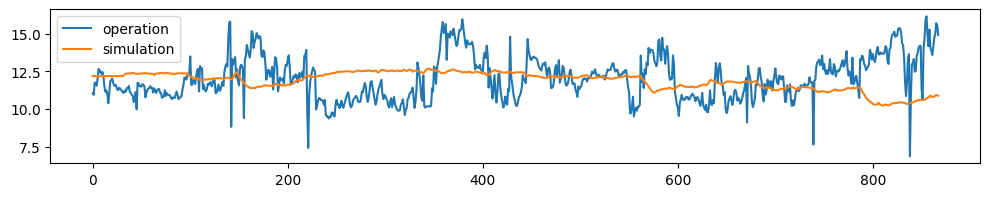

In [ ]:
for i in range(y.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(generator.y_scaler.inverse_transform(generator.y_test)[:, i], label='operation')
    plt.plot(y_test[:, i], label='simulation')
    plt.legend()
    plt.show()


#### Evaluate

In [ ]:
evaluator = Evaluator()

for i in range(output_size):
    metrics_dict = evaluator.measure(generator.y_scaler.inverse_transform(generator.y_test)[:, i], y_test[:, i])
    print(metrics_dict)

{'explained_variance_score': -0.46384664080283833, 'mean_absolute_error': 1.4100893107150314, 'mean_squared_error': 2.9879362823443856, 'root_mean_squared_error': 1.7285648042073476, 'median_absolute_error': 1.2001661053146861, 'mean_absolute_percentage_error': 0.11763785093176538, 'd2_absolute_error_score': -0.23431307131767531, 'd2_pinball_score': -0.23431307131767531, 'r2_score': -0.4666942394935947}


In [ ]:
evaluator = Evaluator()
metrics_dict = evaluator.measure(generator.y_scaler.inverse_transform(generator.y_test), y_test)
metrics_dict

{'explained_variance_score': -0.46384664080283833,
 'mean_absolute_error': 1.4100893107150314,
 'mean_squared_error': 2.9879362823443856,
 'root_mean_squared_error': 1.7285648042073476,
 'median_absolute_error': 1.2001661053146861,
 'mean_absolute_percentage_error': 0.11763785093176538,
 'd2_absolute_error_score': -0.23431307131767531,
 'd2_pinball_score': -0.23431307131767531,
 'r2_score': -0.4666942394935947}

In [ ]:
while True:
    time.sleep(1)
    pass

KeyboardInterrupt: 

### Iron Flotation

#### Data

In [ ]:
df = pd.read_csv('./datasets/iron/iron_flotation.csv', decimal=',', parse_dates=["date"], infer_datetime_format=True).set_index('date').astype(float)
df.index = pd.to_datetime(pd.date_range(start=df.index[0], periods=df.shape[0], freq="20s").strftime("%Y-%m-%d %H:%M:%S.%f"))
df = df.resample("20s").interpolate(method="linear", limit_direction="both", axis=0)
df.index.name = "date_time"
df.interpolate(method="linear", limit_direction="both", axis=0)
df.fillna(method='ffill', axis=0, inplace=True)

df = df.iloc[450000:500000, :]

/tmp/ipykernel_2083456/2460477616.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('./datasets/iron/iron_flotation.csv', decimal=',', parse_dates=["date"], infer_datetime_format=True).set_index('date').astype(float)


In [ ]:
# Z-score
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23093 entries, 2017-06-22 05:50:20 to 2017-07-03 16:27:20
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   % Iron Feed                   23093 non-null  float64
 1   % Silica Feed                 23093 non-null  float64
 2   Starch Flow                   23093 non-null  float64
 3   Amina Flow                    23093 non-null  float64
 4   Ore Pulp Flow                 23093 non-null  float64
 5   Ore Pulp pH                   23093 non-null  float64
 6   Ore Pulp Density              23093 non-null  float64
 7   Flotation Column 01 Air Flow  23093 non-null  float64
 8   Flotation Column 02 Air Flow  23093 non-null  float64
 9   Flotation Column 03 Air Flow  23093 non-null  float64
 10  Flotation Column 04 Air Flow  23093 non-null  float64
 11  Flotation Column 05 Air Flow  23093 non-null  float64
 12  Flotation Column 06 Air F

In [ ]:
df.head()

% Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
date_time                                                                  
2017-06-22 05:50:20         50.7          22.76      2259.18  456.726973   
2017-06-22 05:50:40         50.7          22.76      2407.68  451.154459   
2017-06-22 05:51:00         50.7          22.76      2326.17  445.581946   
2017-06-22 08:45:40         50.7          22.76      3111.29  523.561000   
2017-06-22 08:46:40         50.7          22.76      2989.81  521.397000   

                     Ore Pulp Flow  Ore Pulp pH  Ore Pulp Density  \
date_time                                                           
2017-06-22 05:50:20     394.662233      10.4718          1.709992   
2017-06-22 05:50:40     395.166977      10.4741          1.706240   
2017-06-22 05:51:00     395.671721      10.4763          1.702487   
2017-06-22 08:45:40     399.043000      10.0045          1.625310   
2017-06-22 08:46:40     399.174000      10.0016          1.624480   

                     Flotation Column 01 Air Flow  \
date_time                                           
2017-06-22 05:50:20                       299.428   
2017-06-22 05:50:40                       297.366   
2017-06-22 05:51:00                       296.631   
2017-06-22 08:45:40                       297.049   
2017-06-22 08:46:40                       303.182   

                     Flotation Column 02 Air Flow  \
date_time                                           
2017-06-22 05:50:20                       298.205   
2017-06-22 05:50:40                       298.123   
2017-06-22 05:51:00                       299.487   
2017-06-22 08:45:40                       293.576   
2017-06-22 08:46:40                       299.874   

                     Flotation Column 03 Air Flow  ...  \
date_time                                          ...   
2017-06-22 05:50:20                       297.316  ...   
2017-06-22 05:50:40                       298.516  ...   
2017-06-22 05:51:00                       301.245  ...   
2017-06-22 08:45:40                       300.359  ...   
2017-06-22 08:46:40                       299.292  ...   

                     Flotation Column 07 Air Flow  Flotation Column 01 Level  \
date_time                                                                      
2017-06-22 05:50:20                       309.862                    398.389   
2017-06-22 05:50:40                       307.495                    394.468   
2017-06-22 05:51:00                       300.146                    390.881   
2017-06-22 08:45:40                       307.546                    395.732   
2017-06-22 08:46:40                       296.060                    366.715   

                     Flotation Column 02 Level  Flotation Column 03 Level  \
date_time                                                                   
2017-06-22 05:50:20                 581.215000                    537.685   
2017-06-22 05:50:40                 581.138000                    629.101   
2017-06-22 05:51:00                 563.008000                    680.913   
2017-06-22 08:45:40                 515.609000                    468.614   
2017-06-22 08:46:40                 308.960667                    388.066   

                     Flotation Column 04 Level  Flotation Column 05 Level  \
date_time                                                                   
2017-06-22 05:50:20                    582.833                    432.628   
2017-06-22 05:50:40                    596.012                    494.198   
2017-06-22 05:51:00                    615.234                    497.355   
2017-06-22 08:45:40                    372.186                    424.562   
2017-06-22 08:46:40                    419.438                    389.706   

                     Flotation Column 06 Level  Flotation Column 07 Level  \
date_time                                                                   
2017-06-22 05:50:20                    394.554            

In [ ]:
columns = [
    "% Iron Feed",
    "% Silica Feed",
    "Starch Flow",
    "Amina Flow",
    "Ore Pulp Flow",
    "Ore Pulp pH",
    "Ore Pulp Density",    
    "Flotation Column 01 Air Flow",
    "Flotation Column 02 Air Flow",
    "Flotation Column 03 Air Flow",
    "Flotation Column 04 Air Flow",
    "Flotation Column 05 Air Flow",
    "Flotation Column 06 Air Flow",
    "Flotation Column 07 Air Flow",
    "Flotation Column 01 Level",
    "Flotation Column 02 Level",
    "Flotation Column 03 Level",
    "Flotation Column 04 Level",
    "Flotation Column 05 Level",
    "Flotation Column 06 Level",
    "Flotation Column 07 Level", 
    "% Iron Concentrate",
    "% Silica Concentrate",
]

input_columns = [
    "% Iron Feed",
    "% Silica Feed",
    "Starch Flow",
    "Amina Flow",
    "Ore Pulp Flow",
    "Ore Pulp pH",
    "Ore Pulp Density",    
    "Flotation Column 01 Air Flow",
    # "Flotation Column 02 Air Flow",
    # "Flotation Column 03 Air Flow",
    "Flotation Column 04 Air Flow",
    "Flotation Column 05 Air Flow",
    "Flotation Column 06 Air Flow",
    "Flotation Column 07 Air Flow",
    "Flotation Column 01 Level",
    "Flotation Column 02 Level",
    # "Flotation Column 03 Level",
    "Flotation Column 04 Level",
    "Flotation Column 05 Level",
    "Flotation Column 06 Level",
    "Flotation Column 07 Level", 
]

input_columns = [
    "% Iron Feed",
    "% Silica Feed",
    "Starch Flow",
    "Amina Flow",
    "Ore Pulp Flow",
    "Ore Pulp pH",
    "Ore Pulp Density",    
    "Flotation Column 01 Air Flow",
    "Flotation Column 02 Air Flow",
    "Flotation Column 03 Air Flow",
    "Flotation Column 04 Air Flow",
    "Flotation Column 05 Air Flow",
    "Flotation Column 06 Air Flow",
    "Flotation Column 07 Air Flow",
    "Flotation Column 01 Level",
    "Flotation Column 02 Level",
    "Flotation Column 03 Level",
    "Flotation Column 04 Level",
    "Flotation Column 05 Level",
    "Flotation Column 06 Level",
    "Flotation Column 07 Level", 
]

output_columns = [
    "% Iron Concentrate",
    "% Silica Concentrate",
]

# threshold = 0.1
# selector = VarianceThreshold(threshold=threshold)
# df_selected = pd.DataFrame(selector.fit_transform(df[input_columns]), columns=df[input_columns].columns[selector.get_support()])
# input_columns = list(df_selected.columns.values)


df.index.names = ["date_time"]
df = df[columns]

<Axes: >

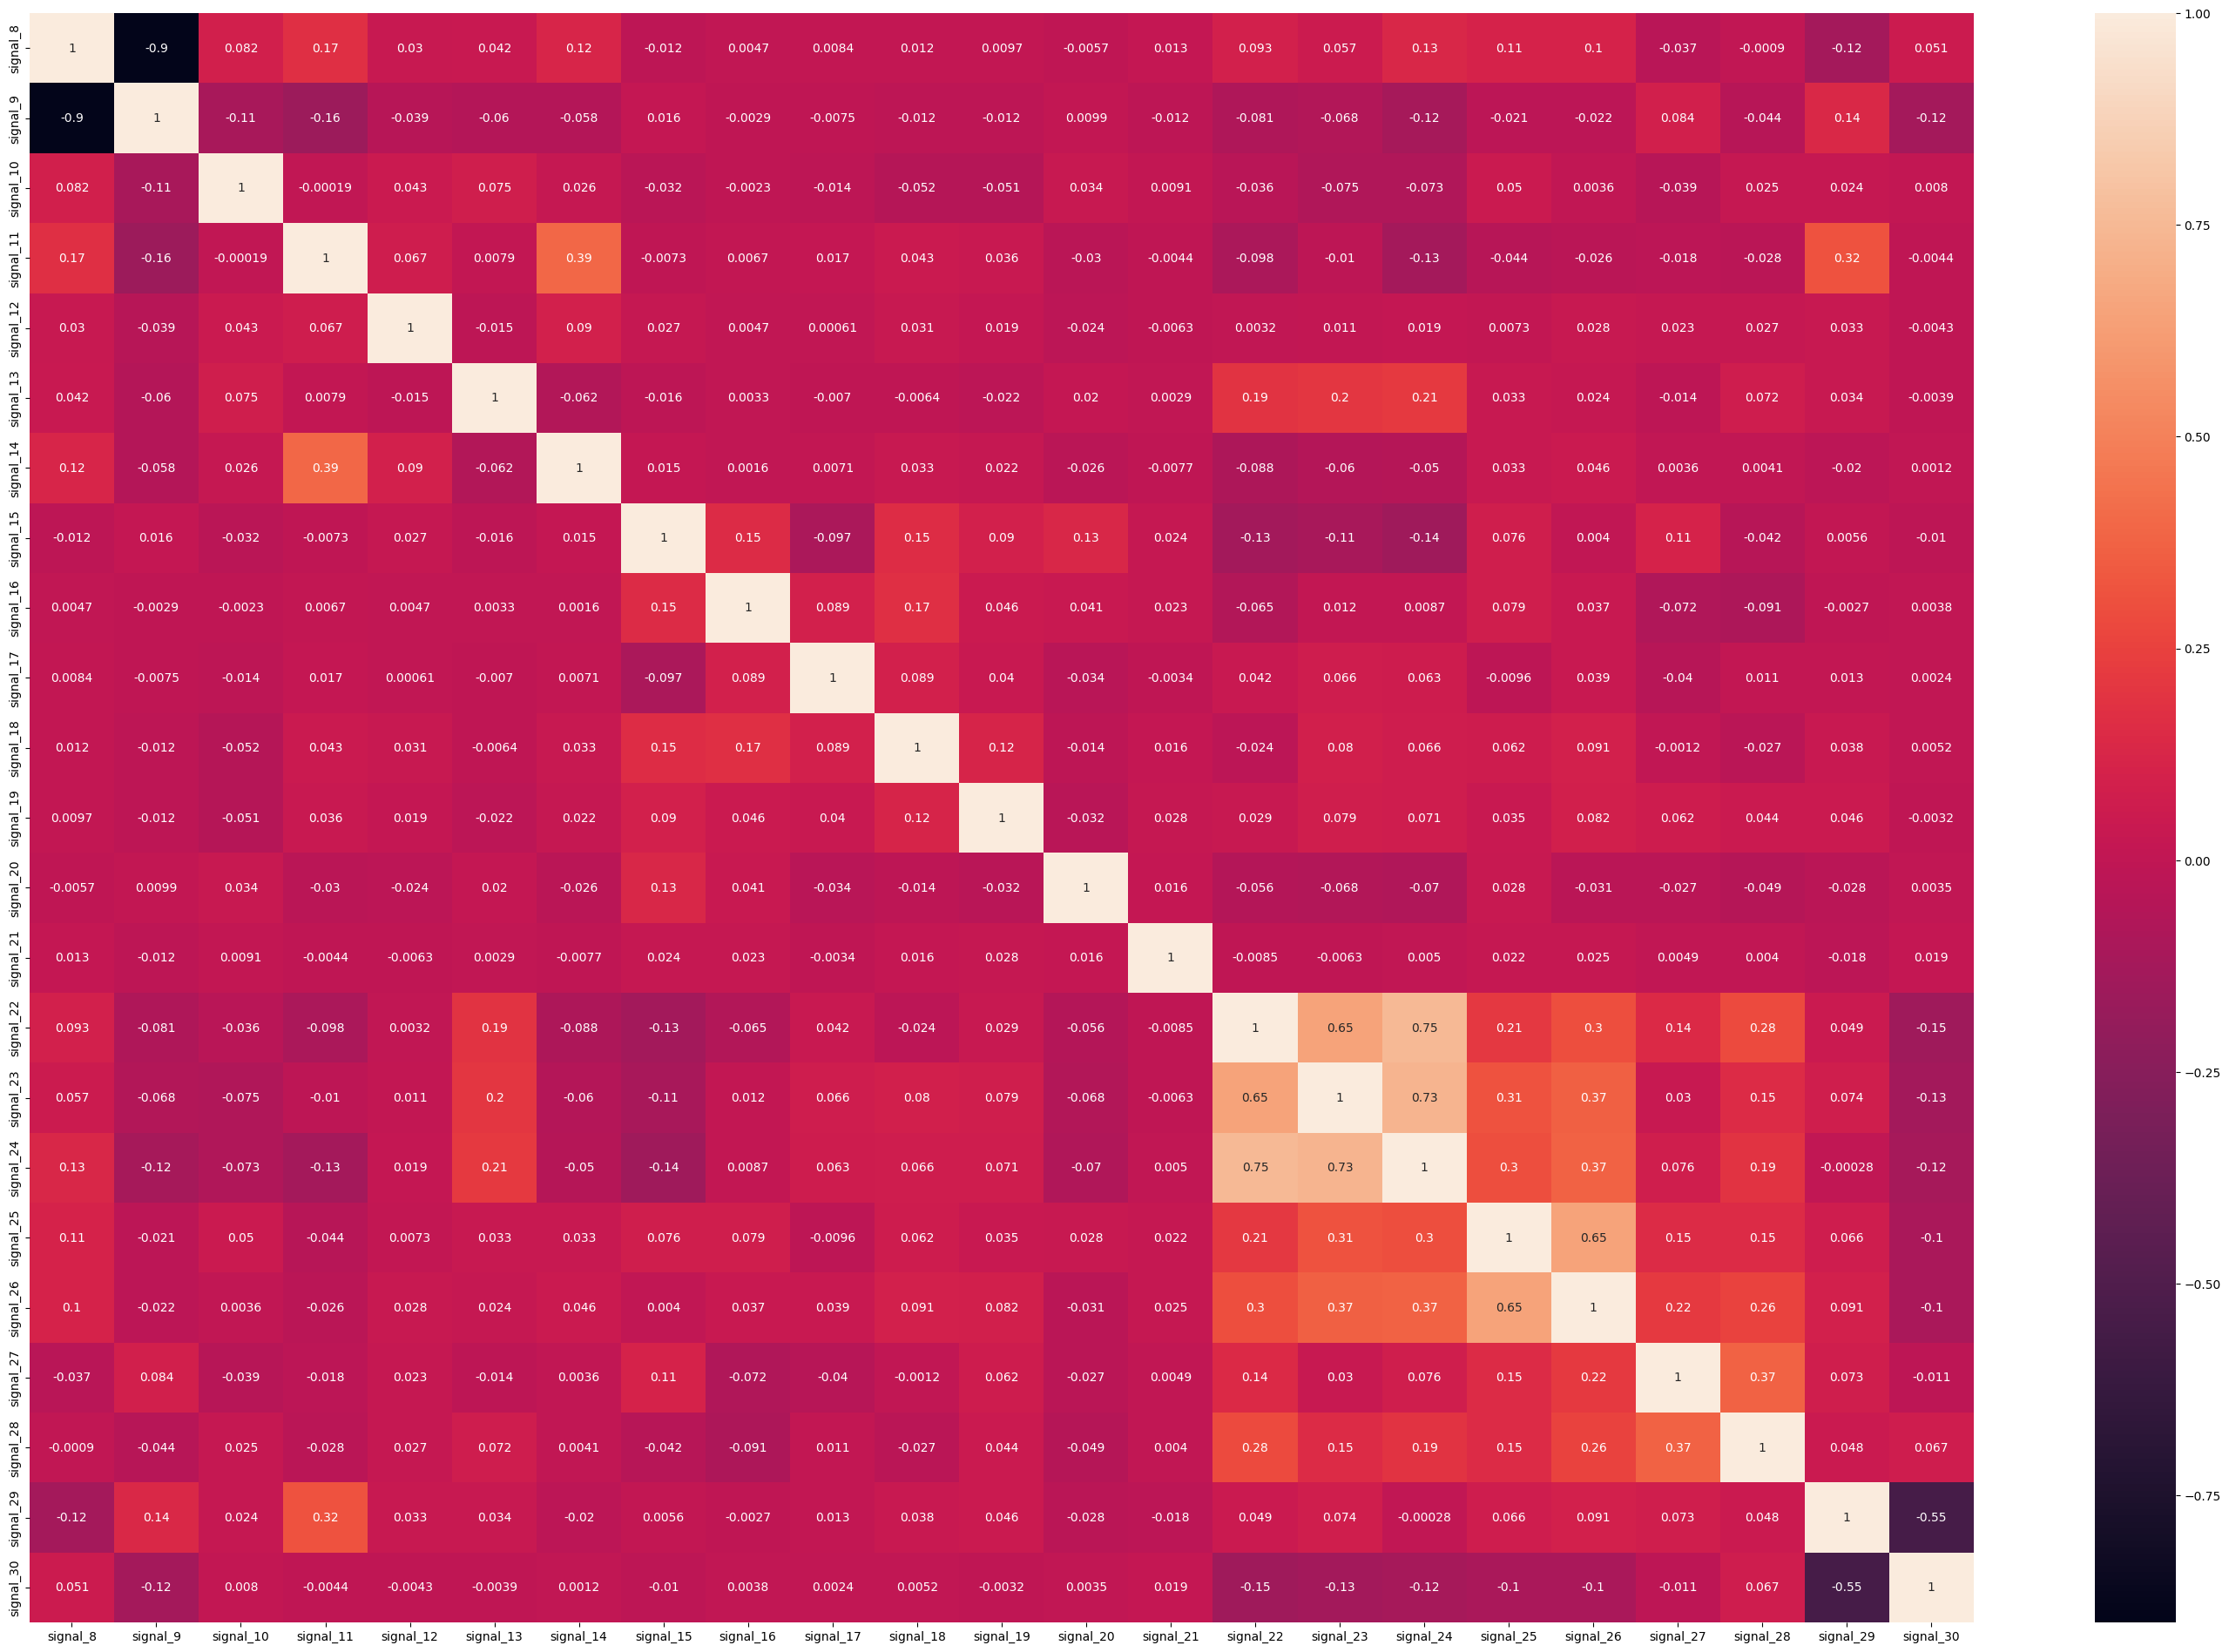

In [ ]:
df_corr = df.corr(method="spearman")

plt.figure(figsize=(36, 24))
sns.heatmap(df_corr, annot=True)

In [ ]:
# df_corr[input_columns][df_corr[input_columns].abs() >= 0.8]
df_corr[input_columns][df_corr[input_columns] >= 0.8]

% Iron Feed  % Silica Feed  Starch Flow  \
% Iron Feed                           1.0            NaN          NaN   
% Silica Feed                         NaN            1.0          NaN   
Starch Flow                           NaN            NaN          1.0   
Amina Flow                            NaN            NaN          NaN   
Ore Pulp Flow                         NaN            NaN          NaN   
Ore Pulp pH                           NaN            NaN          NaN   
Ore Pulp Density                      NaN            NaN          NaN   
Flotation Column 01 Air Flow          NaN            NaN          NaN   
Flotation Column 02 Air Flow          NaN            NaN          NaN   
Flotation Column 03 Air Flow          NaN            NaN          NaN   
Flotation Column 04 Air Flow          NaN            NaN          NaN   
Flotation Column 05 Air Flow          NaN            NaN          NaN   
Flotation Column 06 Air Flow          NaN            NaN          NaN   
Flotation Column 07 Air Flow          NaN            NaN          NaN   
Flotation Column 01 Level             NaN            NaN          NaN   
Flotation Column 02 Level             NaN            NaN          NaN   
Flotation Column 03 Level             NaN            NaN          NaN   
Flotation Column 04 Level             NaN            NaN          NaN   
Flotation Column 05 Level             NaN            NaN          NaN   
Flotation Column 06 Level             NaN            NaN          NaN   
Flotation Column 07 Level             NaN            NaN          NaN   
% Iron Concentrate                    NaN            NaN          NaN   
% Silica Concentrate                  NaN            NaN          NaN   

                              Amina Flow  Ore Pulp Flow  Ore Pulp pH  \
% Iron Feed                          NaN            NaN          NaN   
% Silica Feed                        NaN            NaN          NaN   
Starch Flow                          NaN            NaN          NaN   
Amina Flow                           1.0            NaN          NaN   
Ore Pulp Flow                        NaN            1.0          NaN   
Ore Pulp pH                          NaN            NaN          1.0   
Ore Pulp Density                     NaN            NaN          NaN   
Flotation Column 01 Air Flow         NaN            NaN          NaN   
Flotation Column 02 Air Flow         NaN            NaN          NaN   
Flotation Column 03 Air Flow         NaN            NaN          NaN   
Flotation Column 04 Air Flow         NaN            NaN          NaN   
Flotation Column 05 Air Flow         NaN            NaN          NaN   
Flotation Column 06 Air Flow         NaN            NaN          NaN   
Flotation Column 07 Air Flow         NaN            NaN          NaN   
Flotation Column 01 Level            NaN            NaN          NaN   
Flotation Column 02 Level            NaN            NaN          NaN   
Flotation Column 03 Level            NaN            NaN          NaN   
Flotation Column 04 Level            NaN            NaN          NaN   
Flotation Column 05 Level            NaN            NaN          NaN   
Flotation Column 06 Level            NaN            NaN          NaN   
Flotation Column 07 Level            NaN            NaN          NaN   
% Iron Concentrate                   NaN            NaN          NaN   
% Silica Concentrate                 NaN            NaN          NaN   

                              Ore Pulp Density  Flotation Column 01 Air Flow  \
% Iron Feed                                NaN                           NaN   
% Silica Feed                              NaN                           NaN   
Starch Flow                                NaN                           NaN   
Amina Flow                                 NaN                           NaN   
Ore Pulp Flow                              NaN                           NaN   
Ore Pulp pH                                NaN                      

In [ ]:
input_size = len(input_columns)
output_size = len(output_columns)

x = df[input_columns].values
y = df[output_columns].values

In [ ]:
df[input_columns].describe()

% Iron Feed  % Silica Feed   Starch Flow    Amina Flow  Ore Pulp Flow  \
count  23093.000000   23093.000000  23093.000000  23093.000000   23093.000000   
mean      52.813491      18.631023   3535.301527    491.370329     400.151676   
std        2.884505       4.782203    830.287376     58.840351       4.298747   
min       46.190000       8.100000    998.783769    268.374500     387.322000   
25%       50.800000      15.740000   3027.960000    446.637000     397.220000   
50%       53.630000      16.860000   3533.810000    490.734000     400.267000   
75%       55.210000      21.930000   4107.790000    534.668000     402.888000   
max       59.380000      30.370000   5948.410000    711.994000     412.690061   

        Ore Pulp pH  Ore Pulp Density  Flotation Column 01 Air Flow  \
count  23093.000000      23093.000000                  23093.000000   
mean      10.088301          1.701187                    299.907738   
std        0.240789          0.033935                      1.521380   
min        9.404690          1.583560                    292.313000   
25%        9.937360          1.685260                    299.172000   
50%       10.087200          1.707040                    299.965000   
75%       10.253800          1.724780                    300.806000   
max       10.766200          1.783450                    305.386000   

       Flotation Column 02 Air Flow  Flotation Column 03 Air Flow  ...  \
count                  23093.000000                  23093.000000  ...   
mean                     299.909567                    299.952372  ...   
std                        3.582549                      1.615450  ...   
min                      281.607000                    294.465000  ...   
25%                      297.624000                    298.745000  ...   
50%                      299.818000                    299.843000  ...   
75%                      302.207000                    301.238000  ...   
max                      313.769000                    305.556000  ...   

       Flotation Column 05 Air Flow  Flotation Column 06 Air Flow  \
count                  23093.000000                  23093.000000   
mean                     300.032099                    299.758990   
std                        2.226856                      4.750066   
min                      293.117000                    284.947000   
25%                      298.349000                    295.532000   
50%                      299.927000                    299.730000   
75%                      301.690000                    303.662000   
max                      306.351000                    313.487000   

       Flotation Column 07 Air Flow  Flotation Column 01 Level  \
count                  23093.000000               23093.000000   
mean                     299.791619                 530.165503   
std                        4.698012                  59.497299   
min                      285.030000                 303.851500   
25%                      296.455000                 495.332000   
50%                      299.707000                 509.033000   
75%                      303.135000                 585.481000   
max                      313.518000                 774.598220   

       Flotation Column 02 Level  Flotation Column 03 Level  \
count               23093.000000               23093.000000   
mean                  532.223155                 523.286814   
std                    59.467459                  64.504078   
min                   305.959333                 309.803000   
25%                   493.464000                 493.689000   
50%                   510.243000                 504.179000   
75%                   592.461000                 595.076000   
max                   775.056200                 812.109000   

       Flotation Column 04 Level  Flotation Column 05 Level  \
count               23093.000000               23093.000000   
mean                  491.765963                 491.753335 

In [ ]:
df.mean()

% Iron Feed                       52.813491
% Silica Feed                     18.631023
Starch Flow                     3535.301527
Amina Flow                       491.370329
Ore Pulp Flow                    400.151676
Ore Pulp pH                       10.088301
Ore Pulp Density                   1.701187
Flotation Column 01 Air Flow     299.907738
Flotation Column 02 Air Flow     299.909567
Flotation Column 03 Air Flow     299.952372
Flotation Column 04 Air Flow     299.997233
Flotation Column 05 Air Flow     300.032099
Flotation Column 06 Air Flow     299.758990
Flotation Column 07 Air Flow     299.791619
Flotation Column 01 Level        530.165503
Flotation Column 02 Level        532.223155
Flotation Column 03 Level        523.286814
Flotation Column 04 Level        491.765963
Flotation Column 05 Level        491.753335
Flotation Column 06 Level        449.192279
Flotation Column 07 Level        454.442513
% Iron Concentrate                65.657589
% Silica Concentrate            

In [ ]:
columns = []
ids = np.arange(8, 8 + df.shape[1])
for i in range(input_size + output_size):
    columns.append("signal_" + str(ids[i]))

df.columns = columns
df.to_csv("./datasets/iron/iron_21x2_dataset.csv")

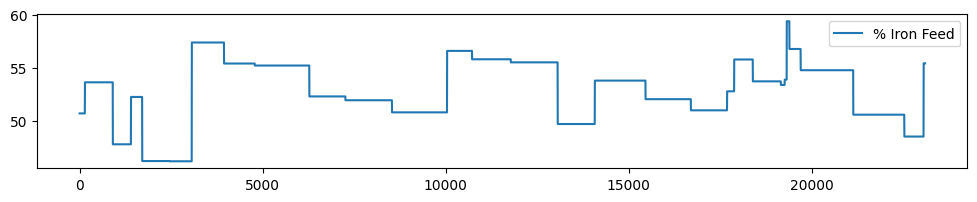

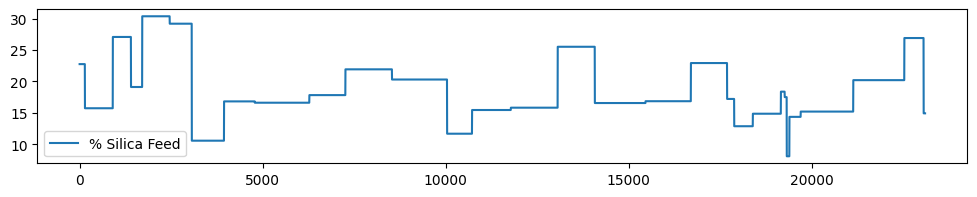

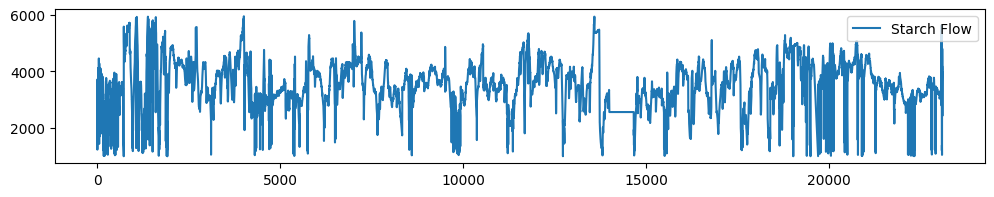

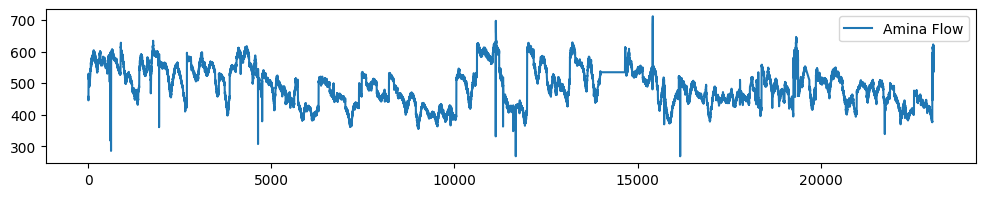

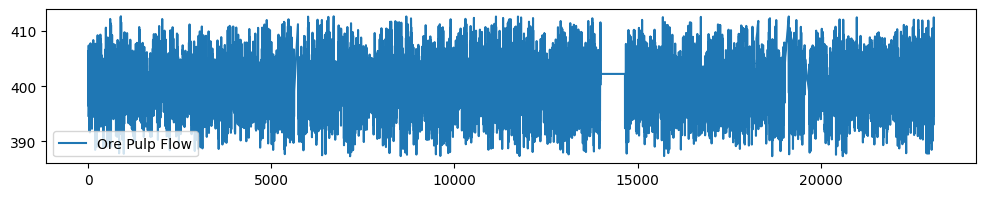

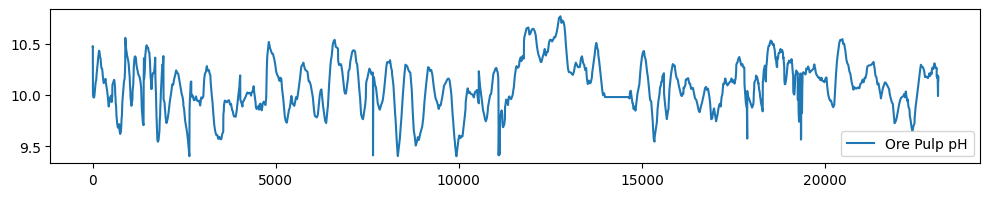

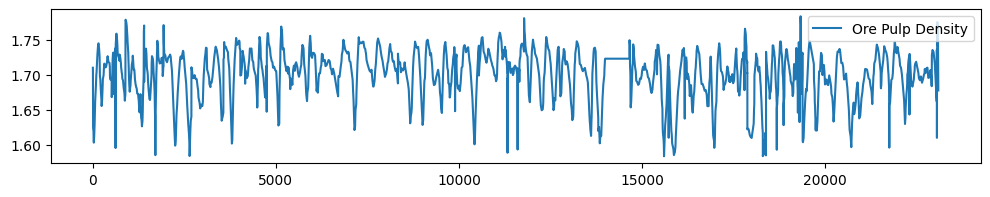

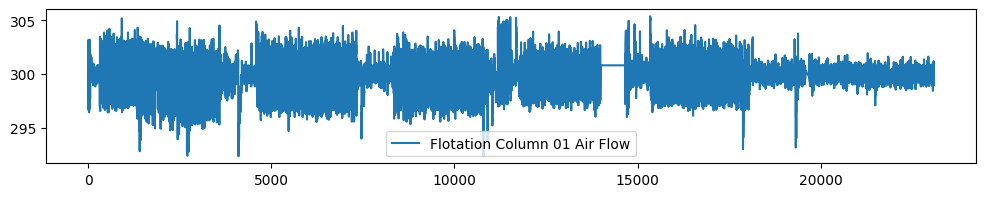

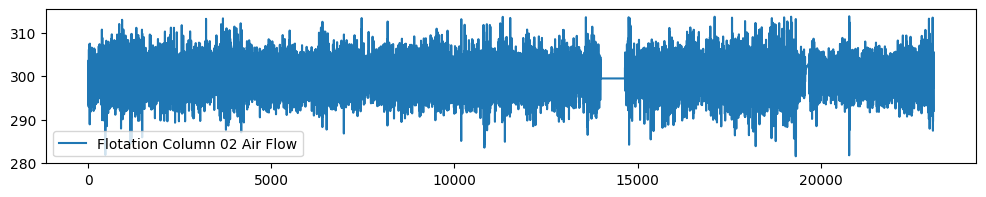

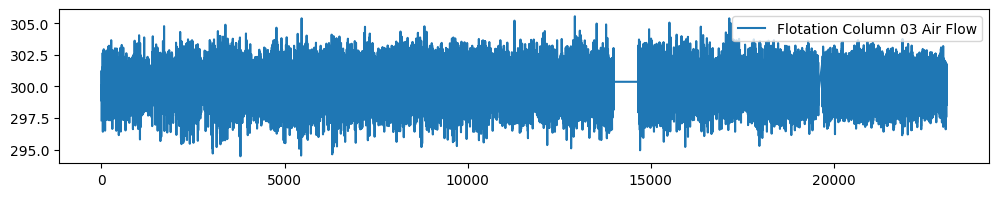

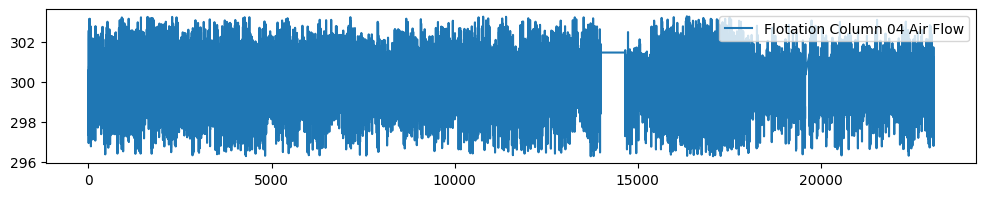

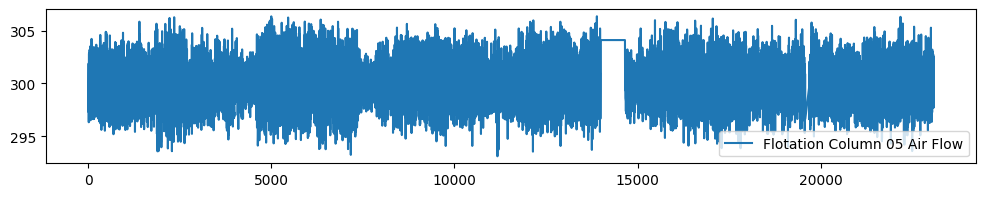

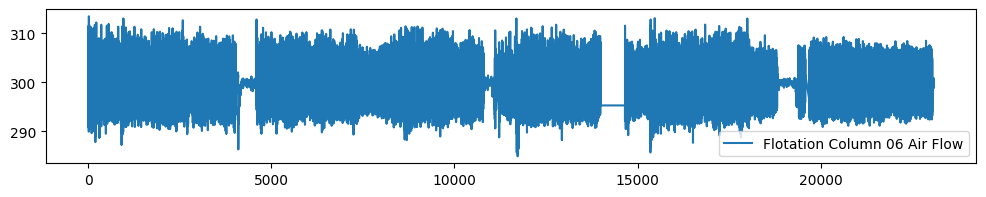

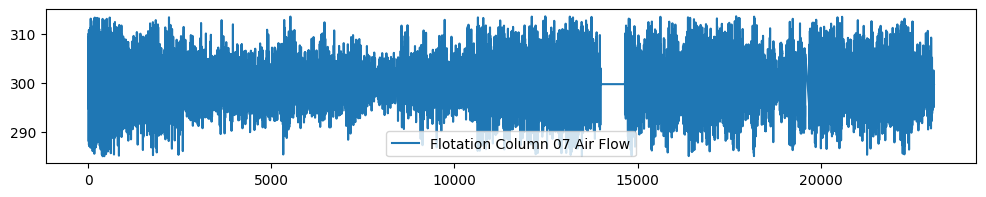

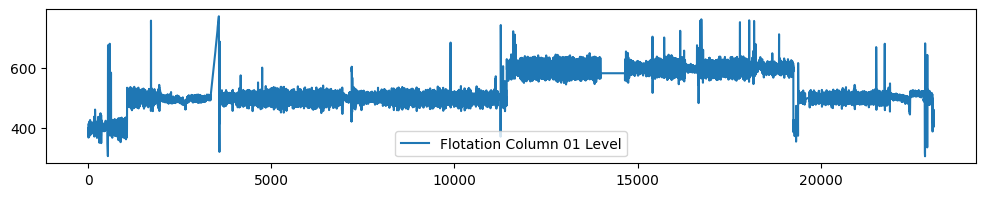

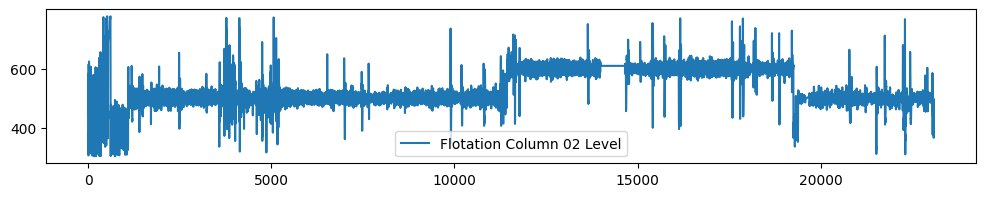

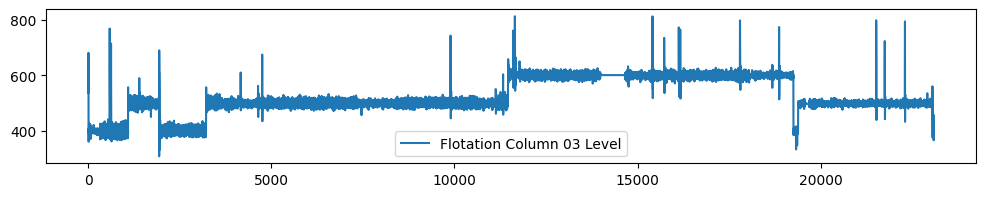

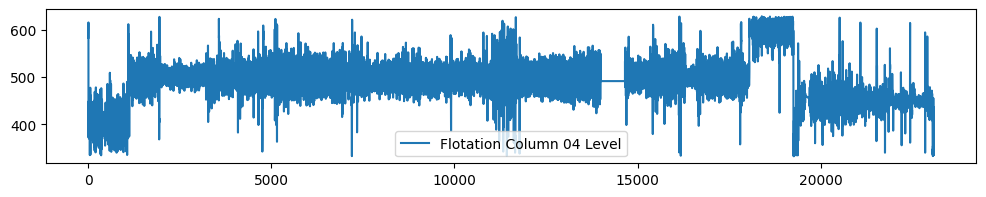

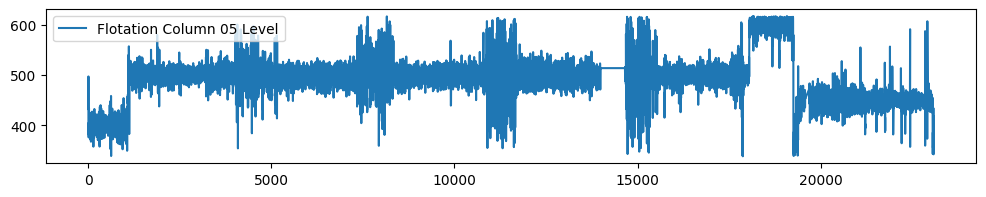

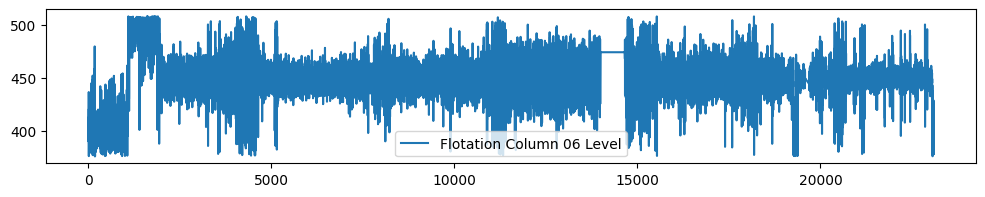

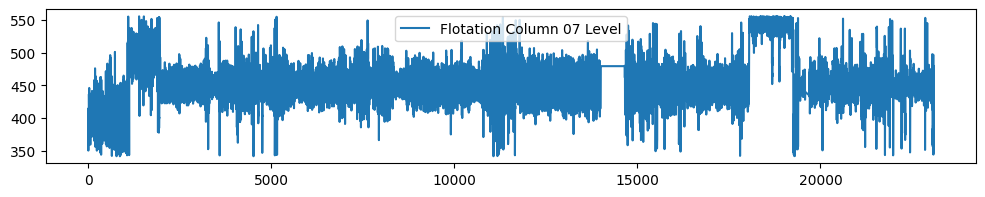

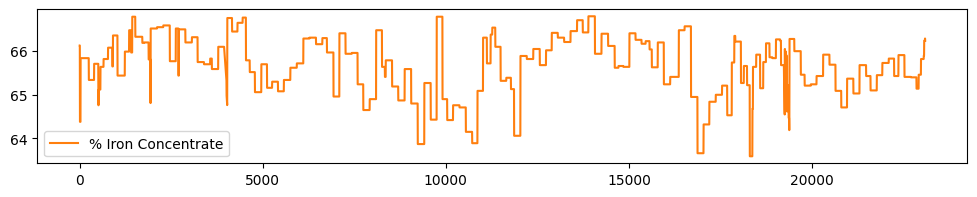

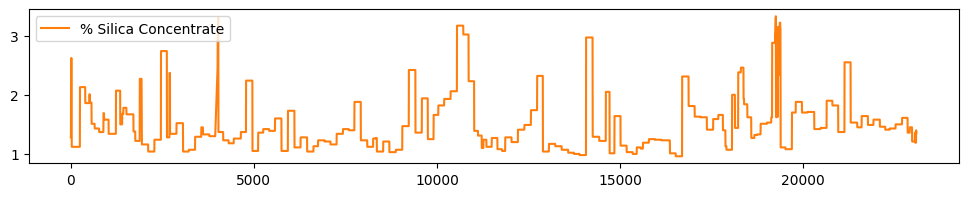

In [ ]:
for i in range(x.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(x[:, i], label=input_columns[i])
    plt.legend()
    plt.show()

for i in range(y.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(y[:, i], label=output_columns[i], color="tab:orange")
    plt.legend()
    plt.show()

In [ ]:
batch_size = 2**5
lag = 2**3

generator = Generator()
train_dataloader, val_dataloader = generator.generate_dataloaders(x, y, lag, batch_size)

#### Model

In [ ]:
config = {
    "input_size": input_size + output_size,
    "output_size": output_size,
    "hidden_size": 2**5,
    "num_layers": 2**1,
    "learning_rate": 1e-3,
    "dropout": 0,
    "lag": lag,
    "epochs": 2**7
}

In [ ]:
repeater = Repeater(**config).to(device)
print(repeater)

Repeater(
  (lstm): LSTM(23, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=2, bias=True)
  (loss_fn): MSELoss()
)


#### Train

In [ ]:
%%time
repeater.fit(train_dataloader, val_dataloader)

Epoch 1/128
361/361 [====================================================================================================] 100%
0.0014s 0.0014s/step - train_loss: 0.03743908 - val_loss: 0.01310518 

Epoch 2/128
361/361 [====================================================================================================] 100%
0.0027s 0.0013s/step - train_loss: 0.02117577 - val_loss: 0.01159358 

Epoch 3/128
361/361 [====================================================================================================] 100%
0.0040s 0.0013s/step - train_loss: 0.01538483 - val_loss: 0.01011758 

Epoch 4/128
361/361 [====================================================================================================] 100%
0.0052s 0.0013s/step - train_loss: 0.01233229 - val_loss: 0.00894259 

Epoch 5/128
361/361 [====================================================================================================] 100%
0.0065s 0.0013s/step - train_loss: 0.01041219 - val_loss: 0.00806639 

Epoch

In [ ]:
model_path = './models/repeater_iron_model.pt'
torch.save(repeater.state_dict(), model_path)

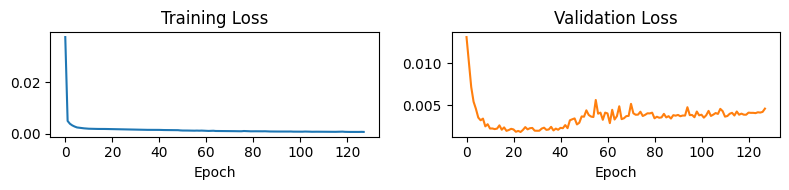

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].plot(repeater.train_loss)
axs[0].set_title('Training Loss')
axs[1].plot(repeater.val_loss, color='tab:orange')
axs[1].set_title('Validation Loss')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='')

fig.tight_layout()

#### Test

In [ ]:
for parameter in repeater.parameters():
  parameter.requires_grad = False
repeater.eval()

Repeater(
  (lstm): LSTM(23, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=2, bias=True)
  (loss_fn): MSELoss()
)

In [ ]:
# y_test_scaled = repeater.test(generator.x_test, (generator.x_val, generator.y_val))
y_test_scaled = repeater.test(generator.x_test)
y_test = generator.y_scaler.inverse_transform(y_test_scaled)

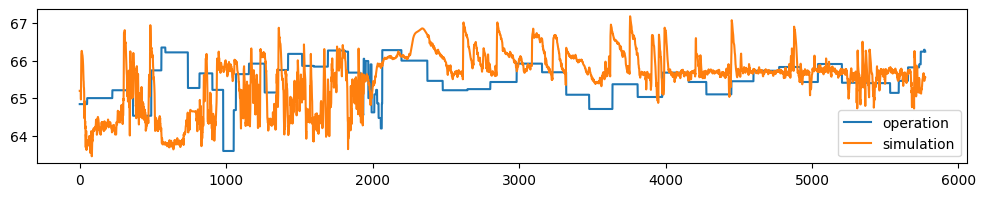

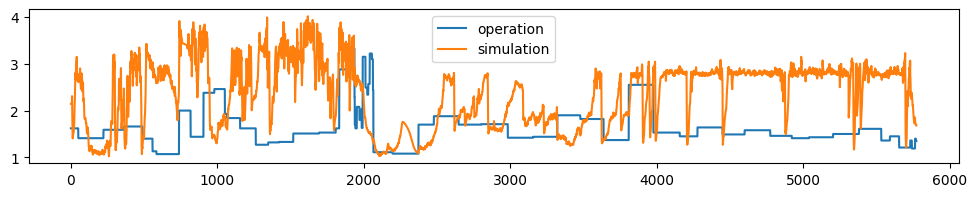

In [ ]:
for i in range(y.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(generator.y_scaler.inverse_transform(generator.y_test)[:, i], label='operation')
    plt.plot(y_test[:, i], label='simulation')
    plt.legend()
    plt.show()


#### Evaluate

In [ ]:
evaluator = Evaluator()

for i in range(output_size):
    metrics_dict = evaluator.measure(generator.y_scaler.inverse_transform(generator.y_test)[:, i], y_test[:, i])
    print(metrics_dict)

{'explained_variance_score': -2.362050991754956, 'mean_absolute_error': 0.6723865928261836, 'mean_squared_error': 0.7681104131012494, 'root_mean_squared_error': 0.8764190853132132, 'median_absolute_error': 0.590799560546877, 'mean_absolute_percentage_error': 0.010276291537118365, 'd2_absolute_error_score': -0.8251332794492663, 'd2_pinball_score': -0.8251332794492663, 'r2_score': -2.3814975273148358}
{'explained_variance_score': -3.0565645768377463, 'mean_absolute_error': 0.9160748166888734, 'mean_squared_error': 1.173967302278858, 'root_mean_squared_error': 1.0834977167852538, 'median_absolute_error': 0.99254741191864, 'mean_absolute_percentage_error': 0.6092917171274604, 'd2_absolute_error_score': -2.666674814193016, 'd2_pinball_score': -2.666674814193016, 'r2_score': -6.962325474866927}


In [ ]:
evaluator = Evaluator()
metrics_dict = evaluator.measure(generator.y_scaler.inverse_transform(generator.y_test), y_test)
metrics_dict

{'explained_variance_score': -2.709307784296491,
 'mean_absolute_error': 0.794230704757548,
 'mean_squared_error': 0.9710388576900543,
 'root_mean_squared_error': 0.9854130391313352,
 'median_absolute_error': 0.7916734862327586,
 'mean_absolute_percentage_error': 0.3097840043322893,
 'd2_absolute_error_score': -1.7459040468213658,
 'd2_pinball_score': -1.7459040468213658,
 'r2_score': -4.671911501091091}

In [ ]:
while True:
    time.sleep(1)
    pass

KeyboardInterrupt: 

### MVV Flotation

#### Data

In [ ]:
sampling_period = "1min"
# sampling_period = "2h"
interpolation_method = "linear"

df1 = pd.read_csv('./datasets/mvv/mvv_rougher_dataset.csv', sep=";", decimal=',', parse_dates=["Data Hora"], infer_datetime_format=True).set_index('Data Hora')
df1.index = pd.to_datetime(df1.index)
df1.index.name = "date_time"
df1 = df1.resample("2h").interpolate(method=interpolation_method, limit_direction="both", axis=0)
# df1.index = pd.to_datetime(pd.date_range(start=df1.index[0], end=df1.index[-1], freq=sampling_period).strftime("%Y-%m-%d %H:%M:%S.%f"))
# df1.interpolate(method=interpolation_method, limit_direction="both", axis=0)
# df1.fillna(method='ffill', axis=0, inplace=True)


df2 = pd.read_csv('./datasets/mvv/mvv_lab_dataset.csv', sep=";", decimal=',', parse_dates=["Data Hora"], infer_datetime_format=True).set_index('Data Hora')
df2.index = pd.to_datetime(df2.index)
df2.index.name = "date_time"
# df2 = df2.resample(sampling_period).interpolate(method=interpolation_method, limit_direction="both", axis=0)
# df2.index = pd.to_datetime(pd.date_range(start=df2.index[0], end=df2.index[-1], freq=sampling_period).strftime("%Y-%m-%d %H:%M:%S.%f"))
# df2.interpolate(method=interpolation_method, limit_direction="both", axis=0)
# df2.fillna(method='ffill', axis=0, inplace=True)

df3 = pd.read_csv('./datasets/mvv/mvv_courier_dataset.csv', sep=";", decimal=',', parse_dates=["Data Hora"], infer_datetime_format=True).set_index('Data Hora')
df3.index = pd.to_datetime(df3.index)
df3.index.name = "date_time"
# df3 = df3.resample(sampling_period).interpolate(method=interpolation_method, limit_direction="both", axis=0)
# df3.index = pd.to_datetime(pd.date_range(start=df3.index[0], periods=df3.shape[0], freq=sampling_period).strftime("%Y-%m-%d %H:%M:%S.%f"))
# df3.interpolate(method=interpolation_method, limit_direction="both", axis=0)
# df3.fillna(method='ffill', axis=0, inplace=True)

df = pd.concat([df1, df2, df3], axis = 1)
df.sort_index(ascending=True, inplace=True)
df = df.resample(sampling_period).interpolate(method=interpolation_method, limit_direction="both", axis=0)
# df.interpolate(method=interpolation_method, limit_direction="both", axis=0, inplace=True)

df = df.iloc[:12500, :]
# df = df.iloc[:6000, :]
# df = df.iloc[:250, :]

/tmp/ipykernel_2034676/1481386423.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df1 = pd.read_csv('./datasets/mvv/mvv_rougher_dataset.csv', sep=";", decimal=',', parse_dates=["Data Hora"], infer_datetime_format=True).set_index('Data Hora')
/tmp/ipykernel_2034676/1481386423.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1 = pd.read_csv('./datasets/mvv/mvv_rougher_dataset.csv', sep=";", decimal=',', parse_dates=["Data Hora"], infer_datetime_format=True).set_index('Data Hora')
/tmp/ipykernel_2034676/1481386423.py:14: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version

<Axes: xlabel='date_time'>

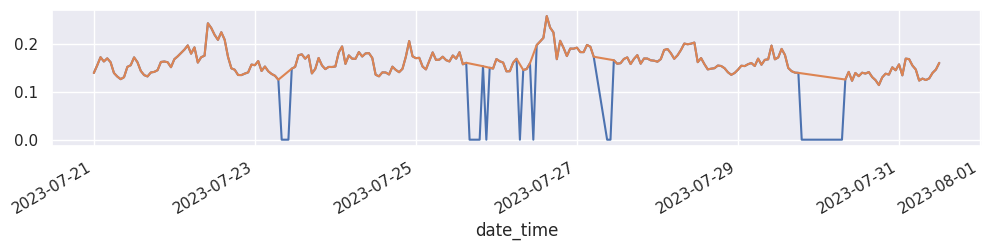

In [ ]:
df31 = df3.iloc[:250, :]
df32 = df3.iloc[:250, :]

Q1 = df32.quantile(0.11, interpolation="linear")
Q3 = df32.quantile(0.89, interpolation="linear")
IQR = Q3 - Q1
df32 = df32[~((df32 < (Q1 - 1.5 * IQR)) | (df32 > (Q3 + 1.5 * IQR))).any(axis=1)]

sns.set(font_scale=1)
plt.figure(figsize=(12, 2))
df31["Rejeito Final Teor de Cu (%)"].plot()
df32["Rejeito Final Teor de Cu (%)"].plot()

<Axes: xlabel='date_time'>

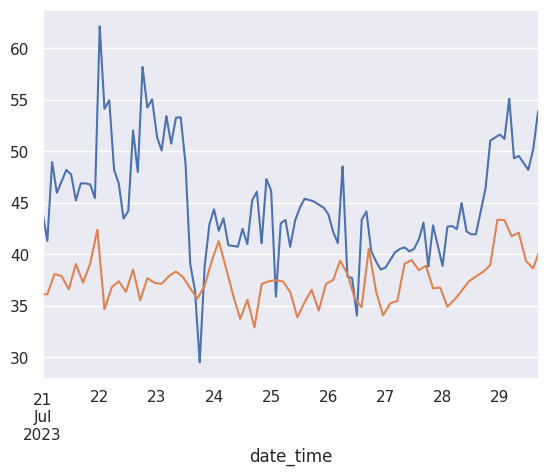

In [ ]:
df["Percentual de sólidos do overflow dos ciclones (%)"].plot()
df["Alimentação da Flotação Percentual de Sólidos (%)"].plot()

In [ ]:
df1 = pd.read_csv('./datasets/mvv/mvv_rougher_dataset.csv', sep=";", decimal=',', parse_dates=["Data Hora"], infer_datetime_format=True).set_index('Data Hora')
df2 = pd.read_csv('./datasets/mvv/mvv_lab_dataset.csv', sep=";", decimal=',', parse_dates=["Data Hora"], infer_datetime_format=True).set_index('Data Hora')
df3 = pd.read_csv('./datasets/mvv/mvv_courier_dataset.csv', sep=";", decimal=',', parse_dates=["Data Hora"], infer_datetime_format=True).set_index('Data Hora')


df1.shape, df2.shape, df3.shape
df1.describe().T
# df3.index.values[0], df3.index.values[-1]

/tmp/ipykernel_2034676/3469165638.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df1 = pd.read_csv('./datasets/mvv/mvv_rougher_dataset.csv', sep=";", decimal=',', parse_dates=["Data Hora"], infer_datetime_format=True).set_index('Data Hora')
/tmp/ipykernel_2034676/3469165638.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1 = pd.read_csv('./datasets/mvv/mvv_rougher_dataset.csv', sep=";", decimal=',', parse_dates=["Data Hora"], infer_datetime_format=True).set_index('Data Hora')
/tmp/ipykernel_2034676/3469165638.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version 

count         mean  \
Taxa de Alimentação da Moagem Massa Úmida (t/h)     6949.0   519.981015   
Taxa de Alimentação da Moagem Massa Seca (t/h)      6949.0   502.338014   
pH Rougher FC-006                                   6949.0     9.985199   
pH Rougher FC-006 - Set Point                       6949.0    10.000000   
pH Rougher CD                                       6949.0    10.317171   
pH Rougher CD - Set Point                           6949.0    10.314969   
Vazão de Ar Rougher CD (N.m³/h)                     6945.0   328.447988   
Vazão de Ar Rougher CD - Set Point (N.m³/h)         6949.0   328.605284   
Jg Rougher CD (cm/s)                                6945.0     0.671963   
Vazão de Ar Rougher FC-001 (N.m³/h)                 6946.0   333.880155   
Vazão de Ar Rougher FC-001 - Set Point (N.m³/h)     6949.0   333.645417   
Jg Rougher FC-001 (cm/s)                            6946.0     0.683159   
Vazão de Ar Rougher FC-002 (N.m³/h)                 6949.0   400.899007   
Vazão de Ar Rougher FC-002 - Set Point (N.m³/h)     6949.0   400.842999   
Jg Rougher FC-002 (cm/s)                            6949.0     0.820059   
Vazão de Ar Rougher FC-003 (N.m³/h)                 6949.0   401.041558   
Vazão de Ar Rougher FC-003 - Set Point (N.m³/h)     6949.0   400.843143   
Jg Rougher FC-003 (cm/s)                            6949.0     0.820471   
Vazão de Ar Rougher FC-004 (N.m³/h)                 6949.0   401.315402   
Vazão de Ar Rougher FC-004 - Set Point (N.m³/h)     6949.0   400.843575   
Jg Rougher FC-004 (cm/s)                            6949.0     0.821000   
Vazão de Ar Rougher FC-005 (N.m³/h)                 6949.0   451.220383   
Vazão de Ar Rougher FC-005 - Set Point (N.m³/h)     6949.0   451.333861   
Jg Rougher FC-005 (cm/s)                            6949.0     0.923183   
Vazão de Ar Rougher FC-006 (N.m³/h)                 6949.0   449.270781   
Vazão de Ar Rougher FC-006 - Set Point (N.m³/h)     6949.0   450.000000   
Jg Rougher FC-006 (cm/s)                            6948.0     0.919316   
Camada de Espuma Rougher CD (mm)                    6949.0   300.649299   
Camada de Espuma Rougher CD - Set Point (mm)        6949.0   299.774048   
Camada de Espuma Rougher FC-001 (mm)                6949.0   250.554886   
Camada de Espuma Rougher FC-001 - Set Point (mm)    6949.0   250.082026   
Camada de Espuma Rougher FC-002 (mm)                6949.0   242.372218   
Camada de Espuma Rougher FC-002 - Set Point (mm)    6949.0   242.276011   
Camada de Espuma Rougher FC-003/FC-004 (mm)         6949.0   287.522941   
Camada de Espuma Rougher FC-003/FC-004 - Set Po...  6949.0   289.558210   
Camada de Espuma Rougher FC-005/FC-006 (mm)         6949.0   243.559541   
Camada de Espuma Rougher FC-005/FC-006 - Set Po...  6949.0   243.133257   
Vazão Cal Rougher CD (L/h)                          2348.0  1780.905362   
Vazão Cal Rougher CD - Set Point (L/h)              2347.0  1782.011632   
Massa Dosada Cal Rougher CD (g/t)                   6946.0   370.896290   
Massa Dosada Cal Rougher CD - Set Point (g/t)       6949.0   537.861563   
Vazão Coletor 1 Rougher FC-002 (L/h)                6949.0    12.367751   
Vazão Coletor 1 Rougher FC-002 - Set Point (L/h)    6895.0    12.782953   
Massa Dosada Coletor 1 Rougher FC-002 (g/t)         6868.0    19.170227   
Massa Dosada Coletor 1 Rougher FC-002 - Set Poi...  6868.0    19.866332   
Massa Dosada Coletor 1 Rougher FC-002 (g/t Cu)      6940.0  2461.208059   
Massa Dosada Coletor 1 Rougher FC-002 - Set Poi...  6884.0  2708.769070   
Percentual de sólidos do overflow dos ciclones (%)  6429.0    43.550744   
Granulometria do overflow dos ciclones (μm)         6949.0   113.788654   

                                                            std     min  \
Taxa de Alimentação da Moagem Massa Úmida (t/h)       11.584889  485.25   
Taxa de Alimentação da Moagem Massa Seca (t/h)        11.739275  470.04   
pH Rougher FC-006                                      0.868447    8.38   
pH

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12500 entries, 2023-07-21 00:00:00 to 2023-07-29 16:19:00
Freq: T
Data columns (total 84 columns):
 #   Column                                                                                Non-Null Count  Dtype  
---  ------                                                                                --------------  -----  
 0   Taxa de Alimentação da Moagem Massa Úmida (t/h)                                       12500 non-null  float64
 1   Taxa de Alimentação da Moagem Massa Seca (t/h)                                        12500 non-null  float64
 2   pH Rougher FC-006                                                                     12500 non-null  float64
 3   pH Rougher FC-006 - Set Point                                                         12500 non-null  float64
 4   pH Rougher CD                                                                         12500 non-null  float64
 5   pH Rougher CD - Set Point             

In [ ]:
df.head()

Taxa de Alimentação da Moagem Massa Úmida (t/h)  \
date_time                                                              
2023-07-21 00:00:00                                        517.50000   
2023-07-21 00:01:00                                        517.29275   
2023-07-21 00:02:00                                        517.08550   
2023-07-21 00:03:00                                        516.87825   
2023-07-21 00:04:00                                        516.67100   

                     Taxa de Alimentação da Moagem Massa Seca (t/h)  \
date_time                                                             
2023-07-21 00:00:00                                         496.950   
2023-07-21 00:01:00                                         496.751   
2023-07-21 00:02:00                                         496.552   
2023-07-21 00:03:00                                         496.353   
2023-07-21 00:04:00                                         496.154   

                     pH Rougher FC-006  pH Rougher FC-006 - Set Point  \
date_time                                                               
2023-07-21 00:00:00              9.940                           10.0   
2023-07-21 00:01:00              9.939                           10.0   
2023-07-21 00:02:00              9.938                           10.0   
2023-07-21 00:03:00              9.937                           10.0   
2023-07-21 00:04:00              9.936                           10.0   

                     pH Rougher CD  pH Rougher CD - Set Point  \
date_time                                                       
2023-07-21 00:00:00      10.370000                       10.3   
2023-07-21 00:01:00      10.369833                       10.3   
2023-07-21 00:02:00      10.369667                       10.3   
2023-07-21 00:03:00      10.369500                       10.3   
2023-07-21 00:04:00      10.369333                       10.3   

                     Vazão de Ar Rougher CD (N.m³/h)  \
date_time                                              
2023-07-21 00:00:00                          395.710   
2023-07-21 00:01:00                          395.741   
2023-07-21 00:02:00                          395.772   
2023-07-21 00:03:00                          395.803   
2023-07-21 00:04:00                          395.834   

                     Vazão de Ar Rougher CD - Set Point (N.m³/h)  \
date_time                                                          
2023-07-21 00:00:00                                        400.0   
2023-07-21 00:01:00                                        400.0   
2023-07-21 00:02:00                                        400.0   
2023-07-21 00:03:00                                        400.0   
2023-07-21 00:04:00                                        400.0   

                     Jg Rougher CD (cm/s)  \
date_time                                   
2023-07-21 00:00:00              0.810000   
2023-07-21 00:01:00              0.810083   
2023-07-21 00:02:00              0.810167   
2023-07-21 00:03:00              0.810250   
2023-07-21 00:04:00              0.810333   

                     Vazão de Ar Rougher FC-001 (N.m³/h)  ...  \
date_time                                                 ...   
2023-07-21 00:00:00                           423.920000  ...   
2023-07-21 00:01:00                           423.962417  ...   
2023-07-21 00:02:00                           424.004833  ...   
2023-07-21 00:03:00                           424.047250  ...   
2023-07-21 00:04:00                           424.089667  ...   

                     Concentrado Cleaner I Teor de Cu (%)  \
date_time                                                   
2023-07-21 00:00:00                             30.520706   
2023-07-21 00:01:00                             30.505144   
2023-07-21 00:02:00                             30.489581   
2023-07-21 00:03:00                             30.474019   
2023-07-21 00:04:00                       

In [ ]:
columns = [
    'Taxa de Alimentação da Moagem Massa Úmida (t/h)',
    # 'Taxa de Alimentação da Moagem Massa Seca (t/h)',
    'pH Rougher FC-006',
    # 'pH Rougher FC-006 - Set Point',
    'pH Rougher CD',
    # 'pH Rougher CD - Set Point',
    'Vazão de Ar Rougher CD (N.m³/h)',
    # 'Vazão de Ar Rougher CD - Set Point (N.m³/h)',
    'Jg Rougher CD (cm/s)',
    'Vazão de Ar Rougher FC-001 (N.m³/h)',
    # 'Vazão de Ar Rougher FC-001 - Set Point (N.m³/h)',
    'Jg Rougher FC-001 (cm/s)',
    'Vazão de Ar Rougher FC-002 (N.m³/h)',
    # 'Vazão de Ar Rougher FC-002 - Set Point (N.m³/h)',
    'Jg Rougher FC-002 (cm/s)',
    'Vazão de Ar Rougher FC-003 (N.m³/h)',
    # 'Vazão de Ar Rougher FC-003 - Set Point (N.m³/h)',
    'Jg Rougher FC-003 (cm/s)',
    'Vazão de Ar Rougher FC-004 (N.m³/h)',
    # 'Vazão de Ar Rougher FC-004 - Set Point (N.m³/h)',
    'Jg Rougher FC-004 (cm/s)',
    'Vazão de Ar Rougher FC-005 (N.m³/h)',
    # 'Vazão de Ar Rougher FC-005 - Set Point (N.m³/h)',
    'Jg Rougher FC-005 (cm/s)',
    'Vazão de Ar Rougher FC-006 (N.m³/h)',
    # 'Vazão de Ar Rougher FC-006 - Set Point (N.m³/h)',
    'Jg Rougher FC-006 (cm/s)',
    'Camada de Espuma Rougher CD (mm)',
    # 'Camada de Espuma Rougher CD - Set Point (mm)',
    'Camada de Espuma Rougher FC-001 (mm)',
    # 'Camada de Espuma Rougher FC-001 - Set Point (mm)',
    'Camada de Espuma Rougher FC-002 (mm)',
    # 'Camada de Espuma Rougher FC-002 - Set Point (mm)',
    'Camada de Espuma Rougher FC-003/FC-004 (mm)',
    # 'Camada de Espuma Rougher FC-003/FC-004 - Set Point (mm)',
    'Camada de Espuma Rougher FC-005/FC-006 (mm)',
    # 'Camada de Espuma Rougher FC-005/FC-006 - Set Point (mm)',
    # 'Sump Operando? (reservatório de contenção dos transbordos para recircular na planta)',
    'Vazão Cal Rougher CD (L/h)',
    # 'Vazão Cal Rougher CD - Set Point (L/h)',
    'Massa Dosada Cal Rougher CD (g/t)',
    # 'Massa Dosada Cal Rougher CD - Set Point (g/t)',
    'Vazão Coletor 1 Rougher FC-002 (L/h)',
    # 'Vazão Coletor 1 Rougher FC-002 - Set Point (L/h)',
    'Massa Dosada Coletor 1 Rougher FC-002 (g/t)',
    # 'Massa Dosada Coletor 1 Rougher FC-002 - Set Point (g/t)',
    'Massa Dosada Coletor 1 Rougher FC-002 (g/t Cu)',
    # 'Massa Dosada Coletor 1 Rougher FC-002 - Set Point (g/t Cu)',
    # 'Percentual de sólidos do overflow dos ciclones (%)',
    'Granulometria do overflow dos ciclones (μm)',
    # 'Alimentação da Flotação Percentual de Sólidos (%)',
    'Alimentação da Flotação Teor de Cu (%)',
    'Alimentação da Flotação Teor de Fe (%)',
    'Alimentação da Flotação Teor de Mg (%)',
    'Alimentação da Flotação Teor de Ni (%)',
    'Alimentação da Flotação Teor de SiO2 (%)',
    # 'Rejeito Rougher Percentual de Sólidos (%)',
    'Rejeito Rougher Teor de Cu (%)',
    'Rejeito Rougher Teor de Fe (%)',
    'Rejeito Rougher Teor de Mg (%)',
    'Rejeito Rougher Teor de Ni (%)',
    'Rejeito Rougher Teor de SiO2 (%)',
    # 'Concentrado Rougher CD Percentual de Sólidos (%)',
    'Concentrado Rougher CD Teor de Cu (%)',
    'Concentrado Rougher CD Teor de Fe (%)',
    'Concentrado Rougher CD Teor de Mg (%)',
    'Concentrado Rougher CD Teor de Ni (%)',
    'Concentrado Rougher CD Teor de SiO2 (%)',
    # 'Concentrado Rougher FC-001 Percentual de Sólidos (%)',
    'Concentrado Rougher FC-001 Teor de Cu (%)',
    'Concentrado Rougher FC-001 Teor de Fe (%)',
    'Concentrado Rougher FC-001 Teor de Mg (%)',
    'Concentrado Rougher FC-001 Teor de Ni (%)',
    'Concentrado Rougher FC-001 Teor de SiO2 (%)',
    # 'Concentrado Cleaner I Teor de Cu (%)',
    # 'Concentrado Cleaner II Teor de Cu (%)',
    'Concentrado Final Teor de Cu (%)',
    # 'Concentrado Rougher Teor de Cu (%)',
    # 'Concentrado Cleaner Scavanger Teor de Cu (%)',
    # 'Alimentação Flotração Teor de Cu (%)',
    # 'Rejeito Cleaner I Teor de Cu (%)',
    'Rejeito Final Teor de Cu (%)',
    # 'Rejeito Rougher Teor de Cu (%)',
    # 'Rejeito Cleaner Scavanger Teor de Cu (%)'
 ]
columns = [
    'Taxa de Alimentação da Moagem Massa Úmida (t/h)',
    # 'Taxa de Alimentação da Moagem Massa Seca (t/h)',
    'pH Rougher FC-006',
    # 'pH Rougher FC-006 - Set Point',
    'pH Rougher CD',
    # 'pH Rougher CD - Set Point',
    'Vazão de Ar Rougher CD (N.m³/h)',
    # 'Vazão de Ar Rougher CD - Set Point (N.m³/h)',
    'Jg Rougher CD (cm/s)',
    'Vazão de Ar Rougher FC-001 (N.m³/h)',
    # 'Vazão de Ar Rougher FC-001 - Set Point (N.m³/h)',
    'Jg Rougher FC-001 (cm/s)',
    'Vazão de Ar Rougher FC-002 (N.m³/h)',
    # 'Vazão de Ar Rougher FC-002 - Set Point (N.m³/h)',
    'Jg Rougher FC-002 (cm/s)',
    'Vazão de Ar Rougher FC-003 (N.m³/h)',
    # 'Vazão de Ar Rougher FC-003 - Set Point (N.m³/h)',
    'Jg Rougher FC-003 (cm/s)',
    'Vazão de Ar Rougher FC-004 (N.m³/h)',
    # 'Vazão de Ar Rougher FC-004 - Set Point (N.m³/h)',
    'Jg Rougher FC-004 (cm/s)',
    'Vazão de Ar Rougher FC-005 (N.m³/h)',
    # 'Vazão de Ar Rougher FC-005 - Set Point (N.m³/h)',
    'Jg Rougher FC-005 (cm/s)',
    'Vazão de Ar Rougher FC-006 (N.m³/h)',
    # 'Vazão de Ar Rougher FC-006 - Set Point (N.m³/h)',
    'Jg Rougher FC-006 (cm/s)',
    'Camada de Espuma Rougher CD (mm)',
    # 'Camada de Espuma Rougher CD - Set Point (mm)',
    'Camada de Espuma Rougher FC-001 (mm)',
    # 'Camada de Espuma Rougher FC-001 - Set Point (mm)',
    'Camada de Espuma Rougher FC-002 (mm)',
    # 'Camada de Espuma Rougher FC-002 - Set Point (mm)',
    'Camada de Espuma Rougher FC-003/FC-004 (mm)',
    # 'Camada de Espuma Rougher FC-003/FC-004 - Set Point (mm)',
    'Camada de Espuma Rougher FC-005/FC-006 (mm)',
    # 'Camada de Espuma Rougher FC-005/FC-006 - Set Point (mm)',
    # 'Sump Operando? (reservatório de contenção dos transbordos para recircular na planta)',
    'Vazão Cal Rougher CD (L/h)',
    # 'Vazão Cal Rougher CD - Set Point (L/h)',
    'Massa Dosada Cal Rougher CD (g/t)',
    # 'Massa Dosada Cal Rougher CD - Set Point (g/t)',
    'Vazão Coletor 1 Rougher FC-002 (L/h)',
    # 'Vazão Coletor 1 Rougher FC-002 - Set Point (L/h)',
    'Massa Dosada Coletor 1 Rougher FC-002 (g/t)',
    # 'Massa Dosada Coletor 1 Rougher FC-002 - Set Point (g/t)',
    'Massa Dosada Coletor 1 Rougher FC-002 (g/t Cu)',
    # 'Massa Dosada Coletor 1 Rougher FC-002 - Set Point (g/t Cu)',
    'Percentual de sólidos do overflow dos ciclones (%)',
    'Granulometria do overflow dos ciclones (μm)',
    'Alimentação da Flotação Percentual de Sólidos (%)',
    'Alimentação da Flotação Teor de Cu (%)',
    'Alimentação da Flotação Teor de Fe (%)',
    'Alimentação da Flotação Teor de Mg (%)',
    'Alimentação da Flotação Teor de Ni (%)',
    'Alimentação da Flotação Teor de SiO2 (%)',
    # 'Rejeito Rougher Percentual de Sólidos (%)',
    'Rejeito Rougher Teor de Cu (%)',
    'Rejeito Rougher Teor de Fe (%)',
    'Rejeito Rougher Teor de Mg (%)',
    'Rejeito Rougher Teor de Ni (%)',
    'Rejeito Rougher Teor de SiO2 (%)',
    # 'Concentrado Rougher CD Percentual de Sólidos (%)',
    'Concentrado Rougher CD Teor de Cu (%)',
    'Concentrado Rougher CD Teor de Fe (%)',
    'Concentrado Rougher CD Teor de Mg (%)',
    'Concentrado Rougher CD Teor de Ni (%)',
    'Concentrado Rougher CD Teor de SiO2 (%)',
    # 'Concentrado Rougher FC-001 Percentual de Sólidos (%)',
    'Concentrado Rougher FC-001 Teor de Cu (%)',
    'Concentrado Rougher FC-001 Teor de Fe (%)',
    'Concentrado Rougher FC-001 Teor de Mg (%)',
    'Concentrado Rougher FC-001 Teor de Ni (%)',
    'Concentrado Rougher FC-001 Teor de SiO2 (%)',
    # 'Concentrado Cleaner I Teor de Cu (%)',
    # 'Concentrado Cleaner II Teor de Cu (%)',
    'Concentrado Final Teor de Cu (%)',
    # 'Concentrado Rougher Teor de Cu (%)',
    # 'Concentrado Cleaner Scavanger Teor de Cu (%)',
    # 'Alimentação Flotração Teor de Cu (%)',
    # 'Rejeito Cleaner I Teor de Cu (%)',
    'Rejeito Final Teor de Cu (%)',
    # 'Rejeito Rougher Teor de Cu (%)',
    # 'Rejeito Cleaner Scavanger Teor de Cu (%)'
 ]


input_columns = [
    # 'Taxa de Alimentação da Moagem Massa Úmida (t/h)',
    # 'Taxa de Alimentação da Moagem Massa Seca (t/h)',
    'pH Rougher FC-006',
    # 'pH Rougher CD',
    # 'Vazão de Ar Rougher CD (N.m³/h)',
    # 'Jg Rougher CD (cm/s)',
    'Vazão de Ar Rougher FC-001 (N.m³/h)',
    # 'Jg Rougher FC-001 (cm/s)',
    # 'Vazão de Ar Rougher FC-002 (N.m³/h)',
    # 'Jg Rougher FC-002 (cm/s)',
    # 'Vazão de Ar Rougher FC-003 (N.m³/h)',
    # 'Jg Rougher FC-003 (cm/s)',
    # 'Vazão de Ar Rougher FC-004 (N.m³/h)',
    # 'Jg Rougher FC-004 (cm/s)',
    # 'Vazão de Ar Rougher FC-005 (N.m³/h)',
    # 'Jg Rougher FC-005 (cm/s)',
    # 'Vazão de Ar Rougher FC-006 (N.m³/h)',
    # 'Jg Rougher FC-006 (cm/s)',
    # 'Camada de Espuma Rougher CD (mm)',
    # 'Camada de Espuma Rougher FC-001 (mm)',
    # 'Camada de Espuma Rougher FC-002 (mm)',
    'Camada de Espuma Rougher FC-003/FC-004 (mm)',
    # 'Camada de Espuma Rougher FC-005/FC-006 (mm)',
    'Vazão Cal Rougher CD (L/h)',
    # 'Massa Dosada Cal Rougher CD (g/t)',
    'Vazão Coletor 1 Rougher FC-002 (L/h)',
    # 'Massa Dosada Coletor 1 Rougher FC-002 (g/t)',
    # 'Massa Dosada Coletor 1 Rougher FC-002 (g/t Cu)',
    # 'Percentual de sólidos do overflow dos ciclones (%)',
    'Granulometria do overflow dos ciclones (μm)',
    # 'Alimentação da Flotação Percentual de Sólidos (%)',
    'Alimentação da Flotação Teor de Cu (%)',
    # 'Alimentação da Flotação Teor de Fe (%)',
    # 'Alimentação da Flotação Teor de Mg (%)',
    # 'Alimentação da Flotação Teor de Ni (%)',
    # 'Alimentação da Flotação Teor de SiO2 (%)',
]

output_columns = [
    # 'Concentrado Rougher CD Percentual de Sólidos (%)',
    # 'Concentrado Rougher CD Teor de Cu (%)',
    # 'Concentrado Rougher CD Teor de Fe (%)',
    # 'Concentrado Rougher CD Teor de Mg (%)',
    # 'Concentrado Rougher CD Teor de Ni (%)',
    # 'Concentrado Rougher CD Teor de SiO2 (%)',
    # 'Concentrado Rougher FC-001 Percentual de Sólidos (%)',
    # 'Concentrado Rougher FC-001 Teor de Cu (%)',
    # 'Concentrado Rougher FC-001 Teor de Fe (%)',
    # 'Concentrado Rougher FC-001 Teor de Mg (%)',
    # 'Concentrado Rougher FC-001 Teor de Ni (%)',
    # 'Concentrado Rougher FC-001 Teor de SiO2 (%)',
    'Concentrado Final Teor de Cu (%)',
    'Rejeito Final Teor de Cu (%)',
]

df = df[columns].astype(float)

# IQR
# Q1 = df.quantile(0.1, interpolation="midpoint")
# Q3 = df.quantile(0.9, interpolation="midpoint")
# IQR = Q3 - Q1
# df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

df = df.resample(sampling_period).interpolate(method=interpolation_method, limit_direction="both", axis=0)

<Axes: >

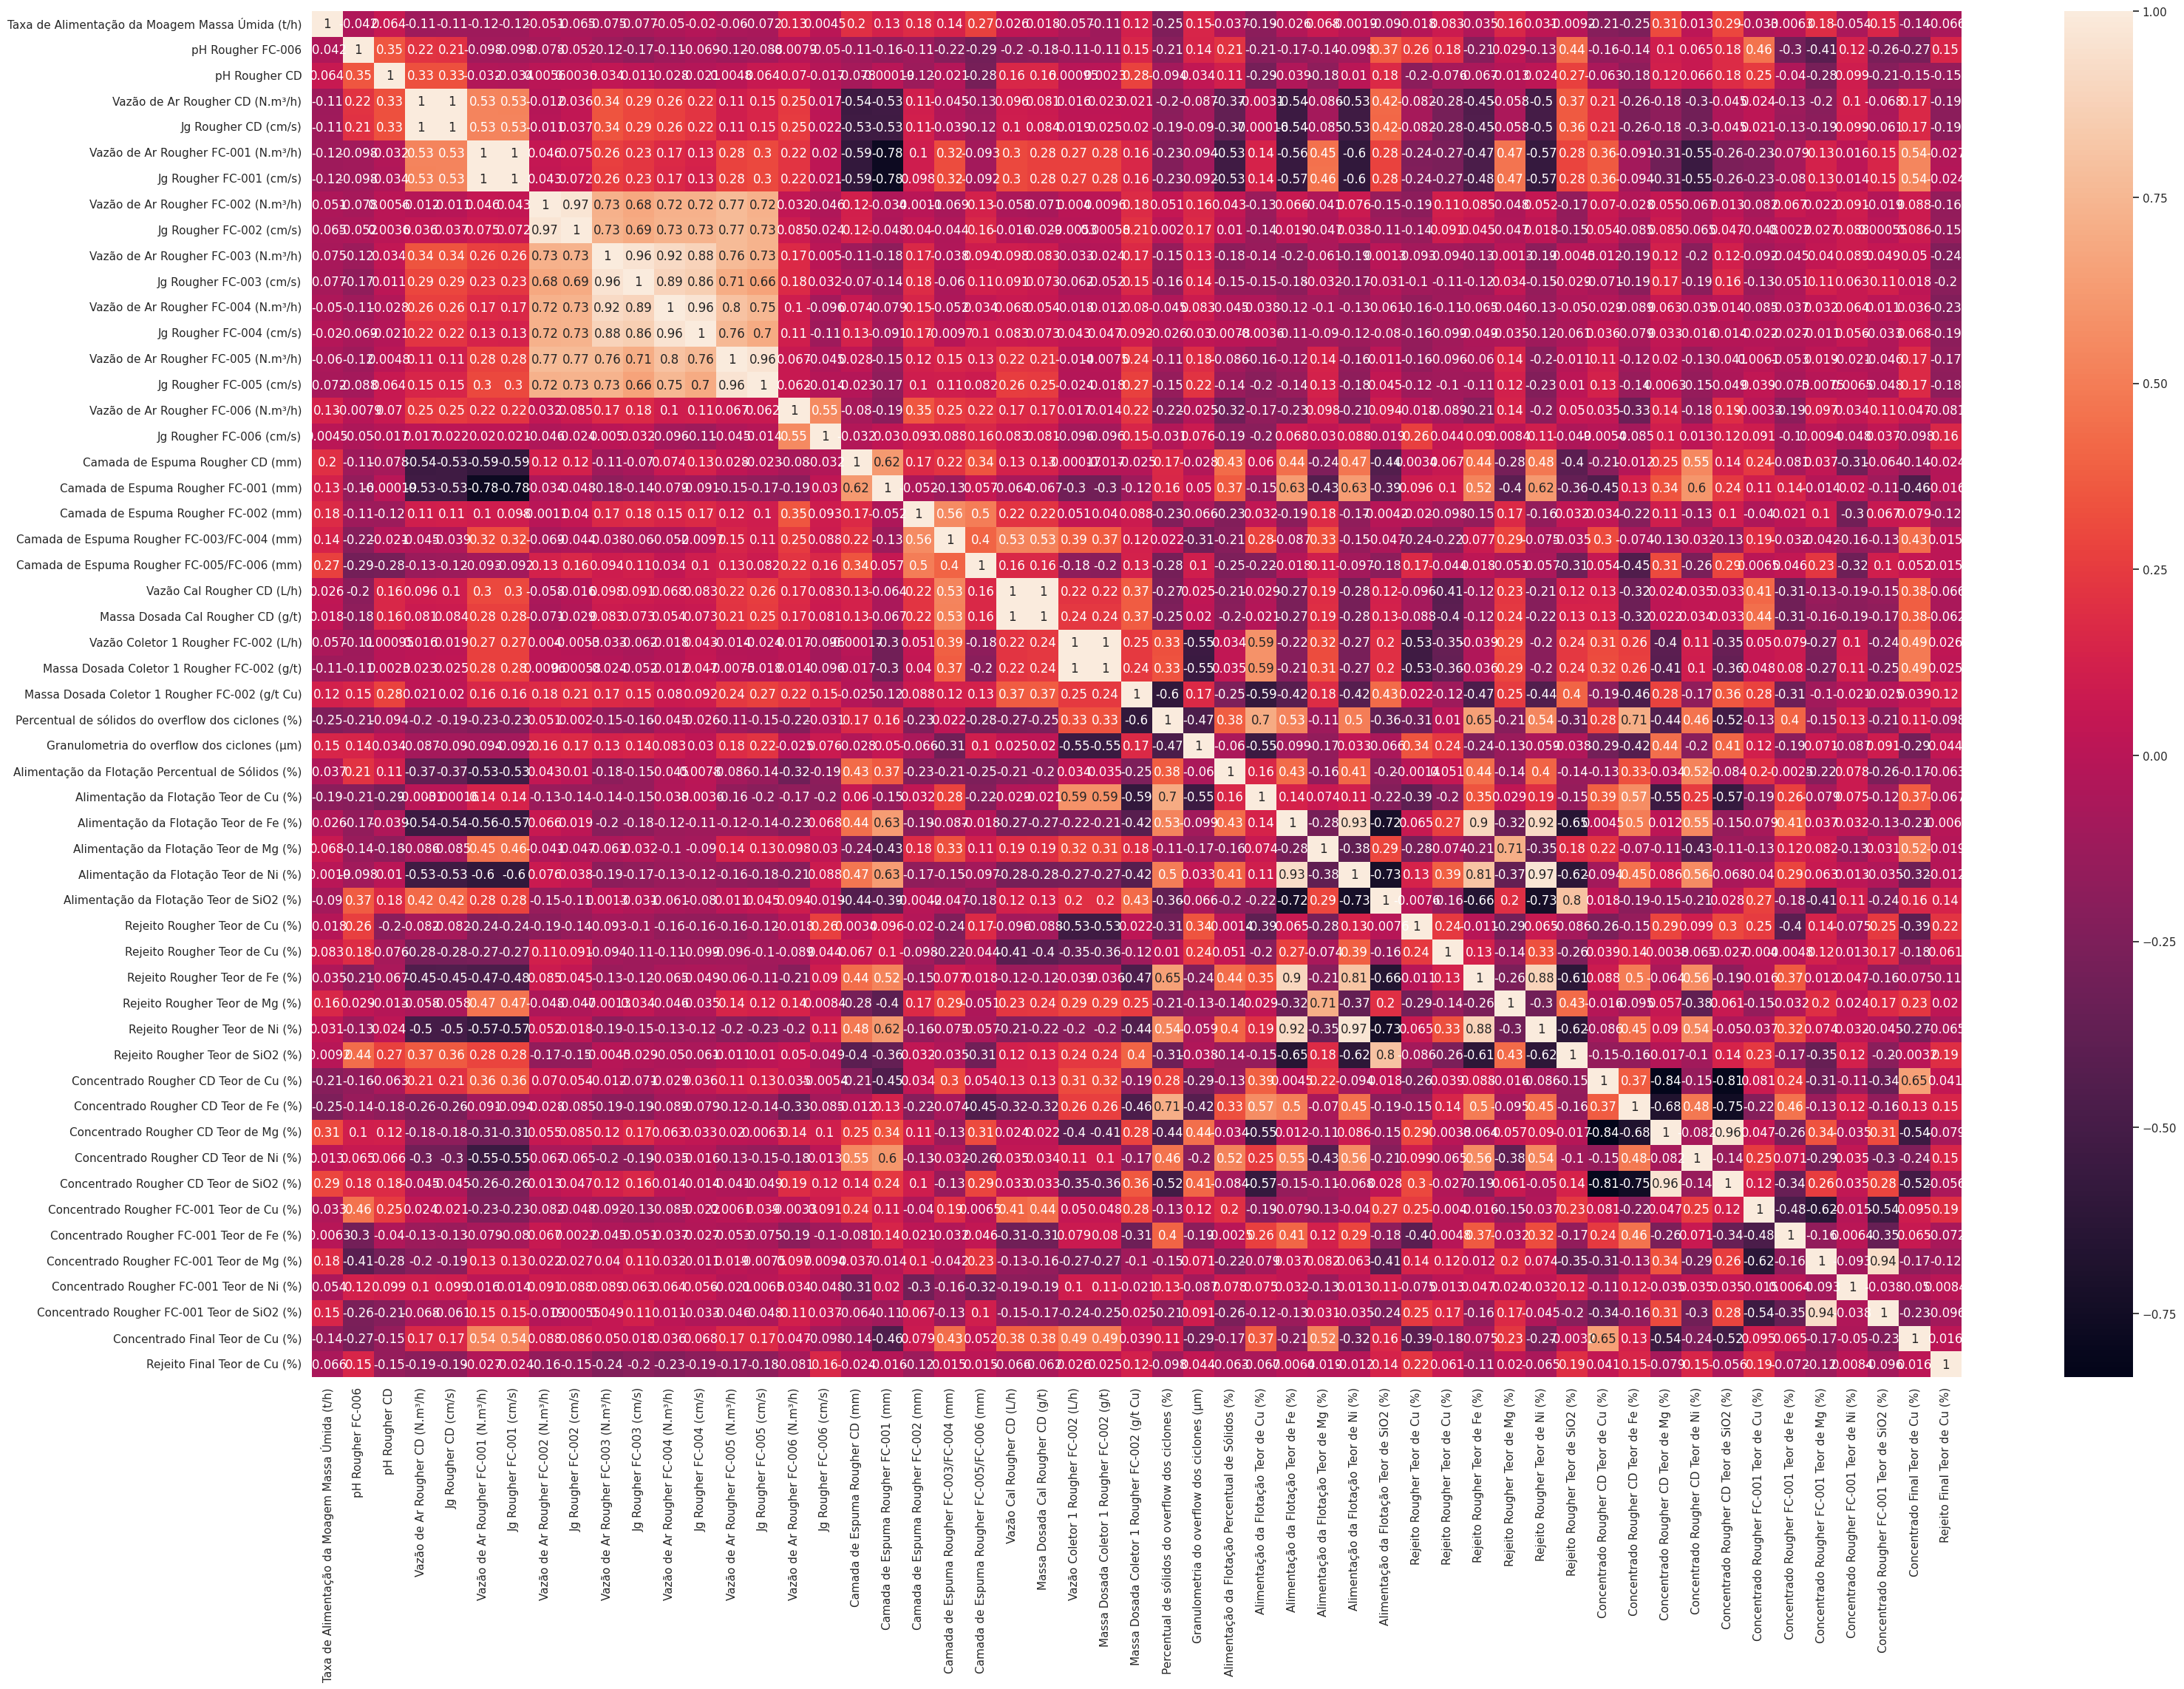

In [ ]:
df_corr = df.corr(method="pearson")

plt.figure(figsize=(36, 24))
sns.heatmap(df_corr, annot=True)

<Axes: >

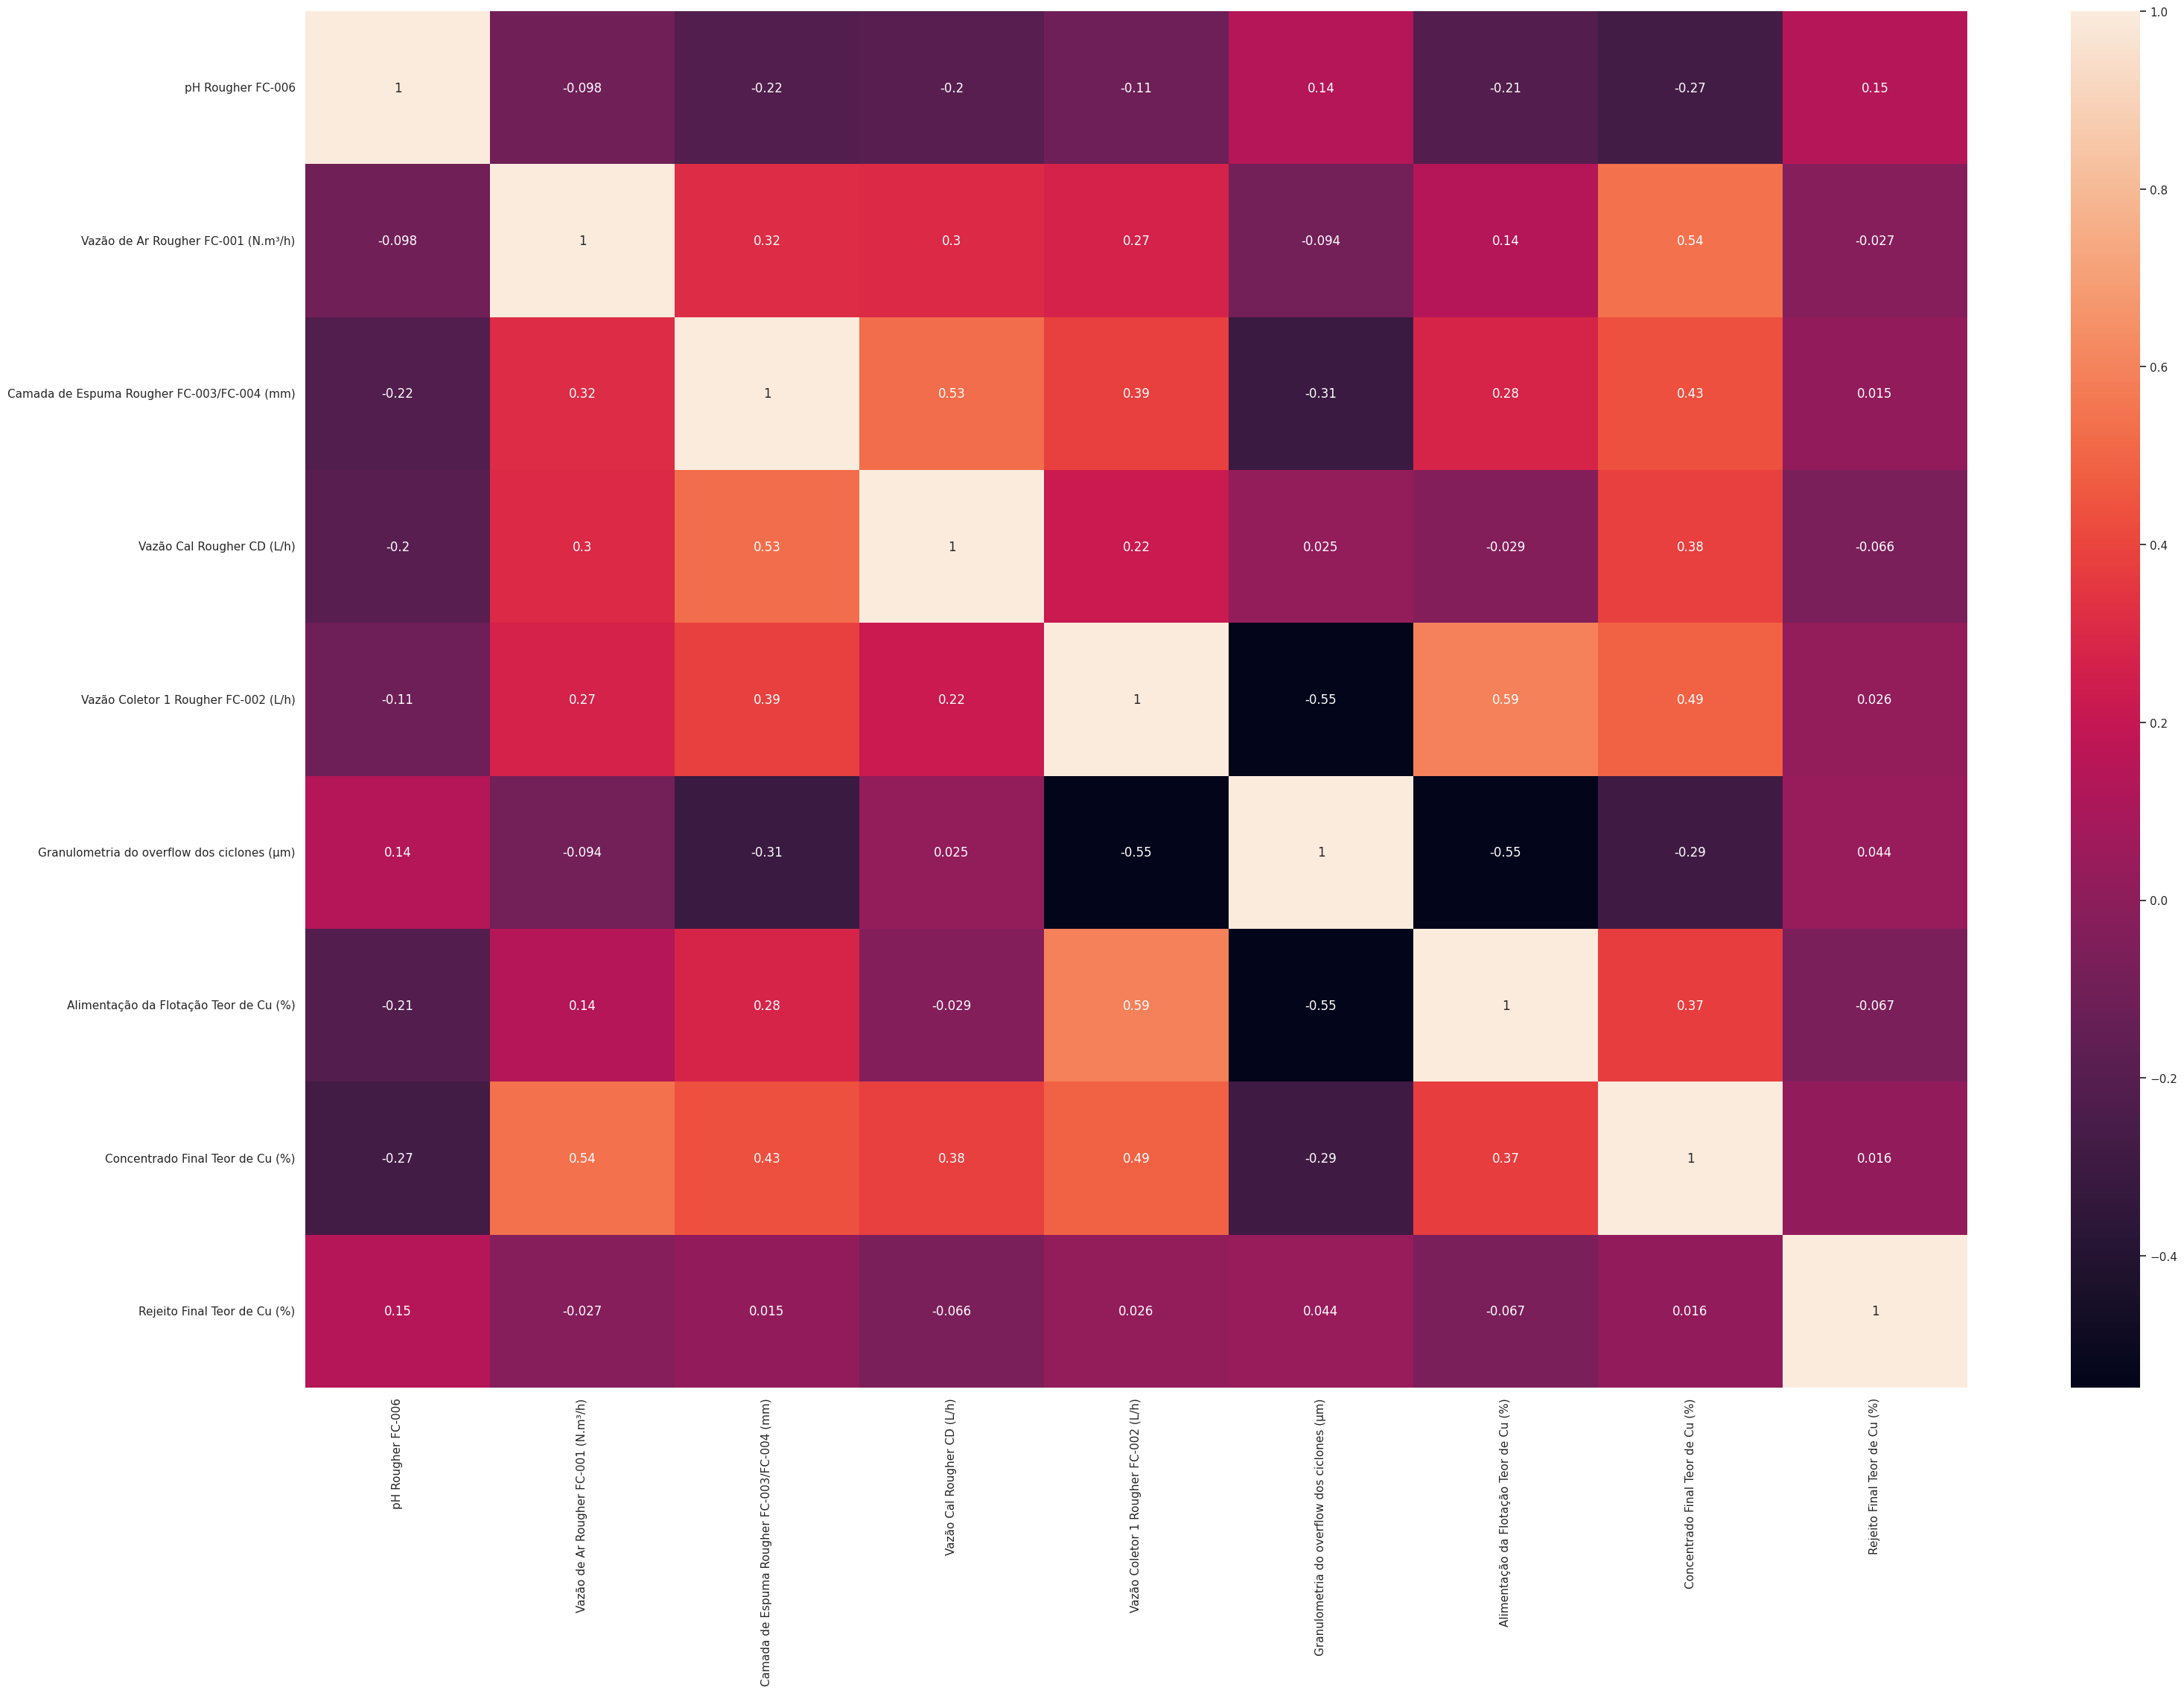

In [ ]:
df_corr = df[input_columns + output_columns].corr(method="pearson")

plt.figure(figsize=(36, 24))

# sns.set(font_scale=2)
sns.heatmap(df_corr, annot=True)

In [ ]:
# plt.figure(figsize=(36, 36))

# columns_a = [
#     "Concentrado Final Teor de Cu (%)",
#     "Vazão de Ar Rougher FC-001 (N.m³/h)",
#     "Camada de Espuma Rougher FC-001 (mm)",
#     "Camada de Espuma Rougher FC-003/FC-004 (mm)",
#     "Vazão Coletor 1 Rougher FC-002 (L/h)"
# ]
# columns_b = [
#     "Rejeito Final Teor de Cu (%)",
#     "pH Rougher FC-006",
#     "pH Rougher CD",
#     "Vazão de Ar Rougher CD (N.m³/h)",
#     "Vazão de Ar Rougher FC-002 (N.m³/h)",
#     "Camada de Espuma Rougher FC-002 (mm)"
# ]

# sns.set(font_scale=0.5)
# sns.pairplot(df[columns_a], kind="kde")

In [ ]:
df_corr[output_columns][np.abs(df_corr[output_columns]) >= 0.1]

Concentrado Final Teor de Cu (%)  \
pH Rougher FC-006                                                   -0.270929   
Vazão de Ar Rougher FC-001 (N.m³/h)                                  0.539423   
Camada de Espuma Rougher FC-003/FC-004 (mm)                          0.433665   
Vazão Cal Rougher CD (L/h)                                           0.379090   
Vazão Coletor 1 Rougher FC-002 (L/h)                                 0.485934   
Granulometria do overflow dos ciclones (μm)                         -0.294290   
Alimentação da Flotação Teor de Cu (%)                               0.374312   
Concentrado Final Teor de Cu (%)                                     1.000000   
Rejeito Final Teor de Cu (%)                                              NaN   

                                             Rejeito Final Teor de Cu (%)  
pH Rougher FC-006                                                0.146749  
Vazão de Ar Rougher FC-001 (N.m³/h)                                   NaN  
Camada de Espuma Rougher FC-003/FC-004 (mm)                           NaN  
Vazão Cal Rougher CD (L/h)                                            NaN  
Vazão Coletor 1 Rougher FC-002 (L/h)                                  NaN  
Granulometria do overflow dos ciclones (μm)                           NaN  
Alimentação da Flotação Teor de Cu (%)                                NaN  
Concentrado Final Teor de Cu (%)                                      NaN  
Rejeito Final Teor de Cu (%)                                     1.000000

In [ ]:
df[input_columns + output_columns].max()

pH Rougher FC-006                                10.370000
Vazão de Ar Rougher FC-001 (N.m³/h)             440.580000
Camada de Espuma Rougher FC-003/FC-004 (mm)     341.780000
Vazão Cal Rougher CD (L/h)                     5305.700000
Vazão Coletor 1 Rougher FC-002 (L/h)             18.200000
Granulometria do overflow dos ciclones (μm)     126.930000
Alimentação da Flotação Teor de Cu (%)            1.927000
Concentrado Final Teor de Cu (%)                 27.473946
Rejeito Final Teor de Cu (%)                      0.257744
dtype: float64

In [ ]:
# df_sel = df_corr[columns][df_corr[columns] >= 0.5]

# for column in columns:
#     print(column)
#     print("".join(["--"] * 2**5))
#     print(df_sel[column].dropna())
#     print("\n")
#     # print(df_sel.loc[df_sel[column].isdigit(), columns])

In [ ]:
input_size = len(input_columns)
output_size = len(output_columns)

x = df[input_columns].values
y = df[output_columns].values

In [ ]:
df[input_columns].describe()
df[input_columns + output_columns].describe()

pH Rougher FC-006  Vazão de Ar Rougher FC-001 (N.m³/h)  \
count       12500.000000                         12500.000000   
mean            9.716763                           392.416910   
std             0.335838                            61.186472   
min             8.840000                           203.440000   
25%             9.450229                           400.292917   
50%             9.737750                           406.530833   
75%             9.995333                           428.752687   
max            10.370000                           440.580000   

       Camada de Espuma Rougher FC-003/FC-004 (mm)  \
count                                 12500.000000   
mean                                    303.731409   
std                                      12.637583   
min                                     270.810000   
25%                                     295.516917   
50%                                     301.809292   
75%                                     313.293542   
max                                     341.780000   

       Vazão Cal Rougher CD (L/h)  Vazão Coletor 1 Rougher FC-002 (L/h)  \
count                12500.000000                          12500.000000   
mean                  1709.106985                             11.872423   
std                   1204.247398                              1.812013   
min                      3.580000                              3.230000   
25%                    824.776000                             10.592375   
50%                   1496.361208                             11.973333   
75%                   2132.445000                             13.376000   
max                   5305.700000                             18.200000   

       Granulometria do overflow dos ciclones (μm)  \
count                                 12500.000000   
mean                                    111.623708   
std                                       7.785225   
min                                      81.340000   
25%                                     106.239875   
50%                                     112.531625   
75%                                     117.313750   
max                                     126.930000   

       Alimentação da Flotação Teor de Cu (%)  \
count                            12500.000000   
mean                                 1.150245   
std                                  0.255126   
min                                  0.784000   
25%                                  0.947533   
50%                                  1.103600   
75%                                  1.236858   
max                                  1.927000   

       Concentrado Final Teor de Cu (%)  Rejeito Final Teor de Cu (%)  
count                      12500.000000                  12500.000000  
mean                          22.121111                      0.155428  
std                            1.820262                      0.042521  
min                           17.852615                      0.000000  
25%                           20.992883                      0.146243  
50%                           21.983131                      0.162329  
75%                           23.182939                      0.175052  
max                           27.473946                      0.257744

In [ ]:
columns_build = []
df_build  = df[input_columns + output_columns]
ids = np.arange(31, 31 + df_build.shape[1])
for i in range(input_size + output_size):
    columns_build.append("signal_" + str(ids[i]))

df_build.columns = columns_build
df_build.to_csv("./datasets/mvv/mvv_15x2_dataset.csv")

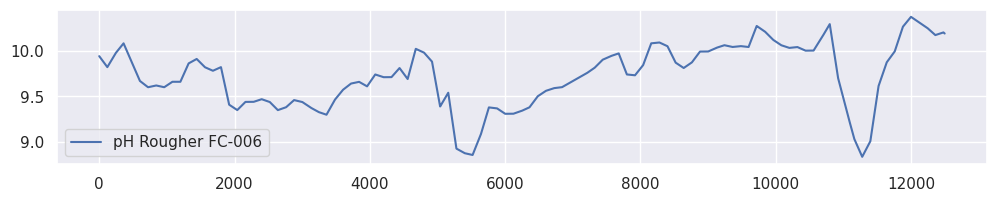

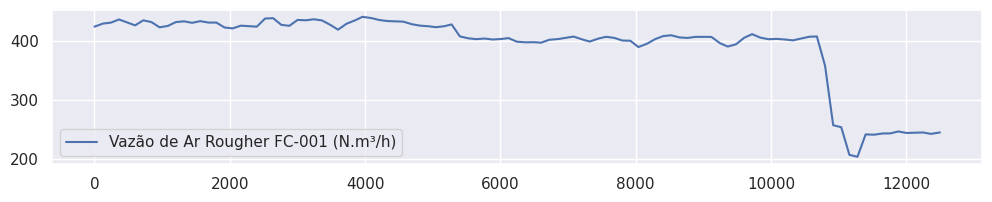

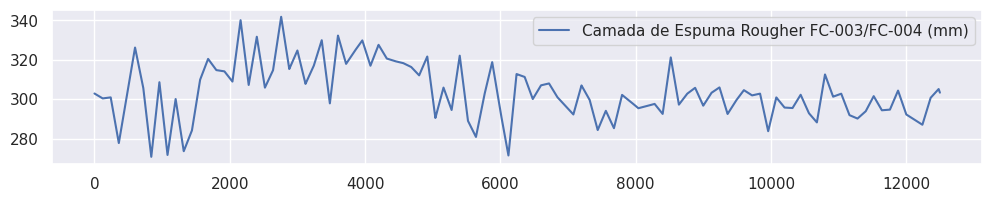

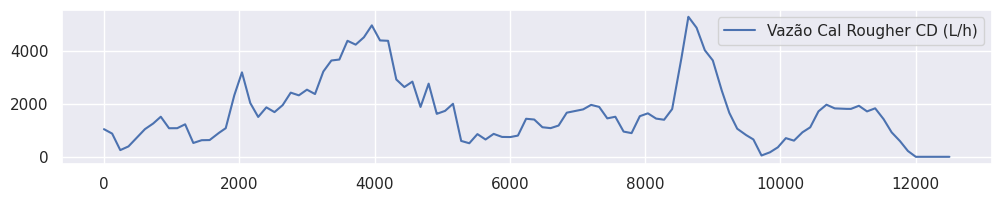

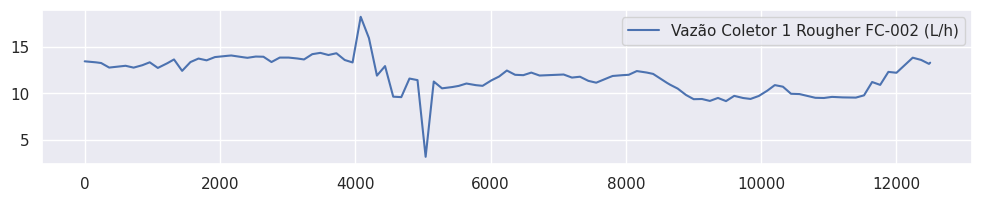

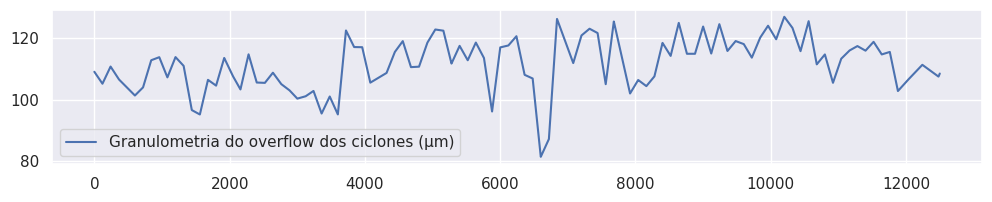

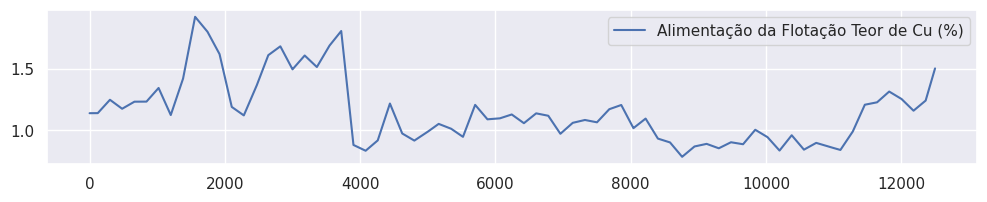

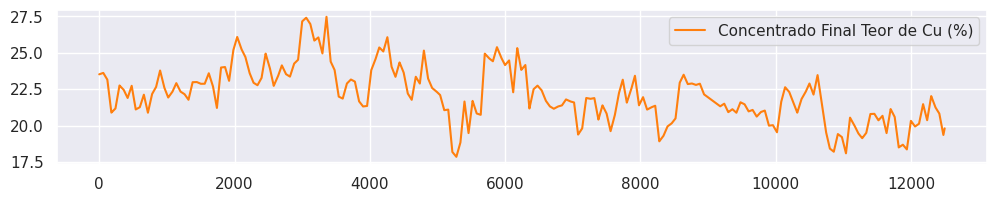

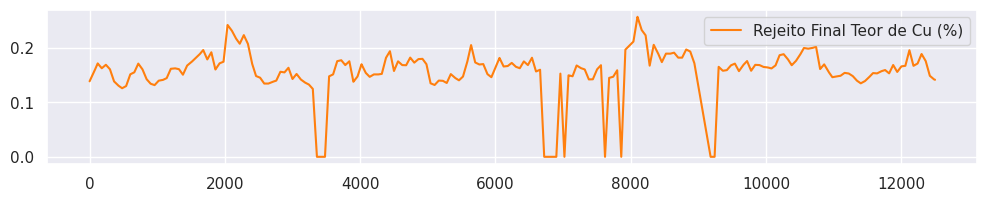

In [ ]:
for i in range(x.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(x[:, i], label=input_columns[i])
    plt.legend()
    plt.show()

for i in range(y.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(y[:, i], label=output_columns[i], color="tab:orange")
    plt.legend()
    plt.show()

In [ ]:
batch_size = 2**5
lag = 2**5

generator = Generator()
train_dataloader, val_dataloader = generator.generate_dataloaders(x, y, lag, batch_size)

#### Model

In [ ]:
config = {
    "input_size": input_size + output_size,
    "output_size": output_size,
    "hidden_size": 2**5,
    "num_layers": 2**1,
    "learning_rate": 1e-3,
    "dropout": 0,
    "lag": lag,
    "epochs": 2**7
}

In [ ]:
repeater = Repeater(**config).to(device)
print(repeater)

Repeater(
  (lstm): LSTM(9, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=2, bias=True)
  (loss_fn): MSELoss()
)


#### Train

In [ ]:
%%time
repeater.fit(train_dataloader, val_dataloader)

Epoch 1/128
195/195 [====================================================================================================] 100%
0.0020s 0.0020s/step - train_loss: 0.02028843 - val_loss: 0.01698111 

Epoch 2/128
195/195 [====================================================================================================] 100%
0.0039s 0.0020s/step - train_loss: 0.01039597 - val_loss: 0.01324624 

Epoch 3/128
195/195 [====================================================================================================] 100%
0.0060s 0.0020s/step - train_loss: 0.00702908 - val_loss: 0.01129523 

Epoch 4/128
195/195 [====================================================================================================] 100%
0.0078s 0.0019s/step - train_loss: 0.00532403 - val_loss: 0.00989049 

Epoch 5/128
195/195 [====================================================================================================] 100%
0.0097s 0.0019s/step - train_loss: 0.00428984 - val_loss: 0.00892161 

Epoch

In [ ]:
repeater.x_min_ = generator.x_scaler.min_.tolist()
repeater.x_scale_ = generator.x_scaler.scale_.tolist()
repeater.x_data_min_ = generator.x_scaler.data_min_.tolist()
repeater.x_data_max_ = generator.x_scaler.data_max_.tolist()
repeater.x_data_range_ = generator.x_scaler.data_range_.tolist()
repeater.x_n_features_in_ = generator.x_scaler.n_features_in_
repeater.x_n_samples_seen_ = generator.x_scaler.n_samples_seen_

repeater.y_min_ = generator.y_scaler.min_.tolist()
repeater.y_scale_ = generator.y_scaler.scale_.tolist()
repeater.y_data_min_ = generator.y_scaler.data_min_.tolist()
repeater.y_data_max_ = generator.y_scaler.data_max_.tolist()
repeater.y_data_range_ = generator.y_scaler.data_range_.tolist()
repeater.y_n_features_in_ = generator.y_scaler.n_features_in_
repeater.y_n_samples_seen_ = generator.y_scaler.n_samples_seen_

model_path = '../database/repeater_7x2.pt'
# torch.save(repeater.state_dict(), model_path)
torch.jit.script(repeater).save(model_path)

In [ ]:
# model_path = './models/repeater_mvv_flotation.pt'
# torch.save(repeater.state_dict(), model_path)

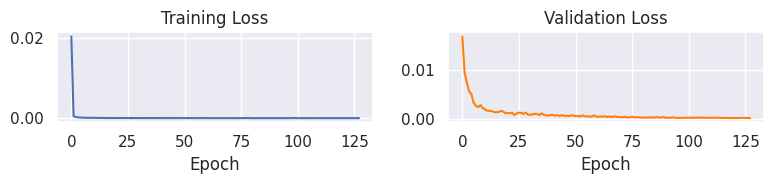

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].plot(repeater.train_loss)
axs[0].set_title('Training Loss')
axs[1].plot(repeater.val_loss, color='tab:orange')
axs[1].set_title('Validation Loss')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='')

fig.tight_layout()

#### Test

In [ ]:
for parameter in repeater.parameters():
  parameter.requires_grad = False
repeater.eval()

Repeater(
  (lstm): LSTM(9, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=2, bias=True)
  (loss_fn): MSELoss()
)

In [ ]:
# y_test_scaled = repeater.test(generator.x_test, (generator.x_val, generator.y_val))
y_test_scaled = repeater.test(generator.x_test)
y_test = generator.y_scaler.inverse_transform(y_test_scaled)

15.856373873629417 %


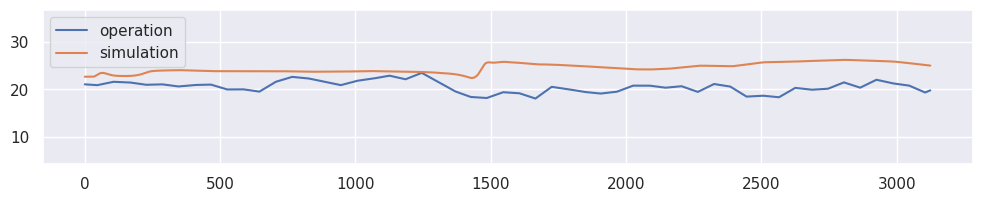

270.45078586096 %


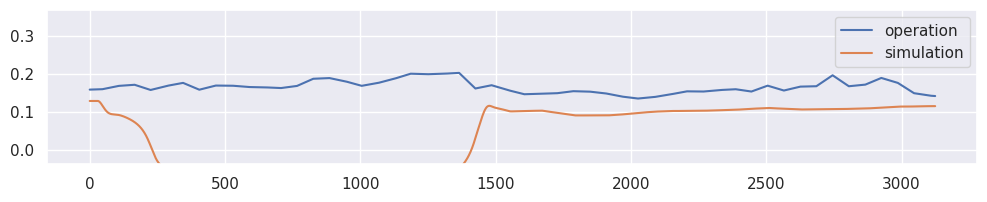

In [ ]:
for i in range(y.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(generator.y_scaler.inverse_transform(generator.y_test)[:, i], label='operation')
    plt.plot(y_test[:, i], label='simulation')
    error = np.mean(np.abs((y_test[:, i] - generator.y_scaler.inverse_transform(generator.y_test)[:, i]) / y_test[:, i]))
    print(error * 100, "%")
    y_delta = np.amax(generator.y_scaler.inverse_transform(generator.y_test)[:, i]) - np.amin(generator.y_scaler.inverse_transform(generator.y_test)[:, i])
    y_mean = np.mean(generator.y_scaler.inverse_transform(generator.y_test)[:, i])
    plt.ylim(y_mean - 3 * y_delta, y_mean + 3 * y_delta)
    plt.legend()
    plt.show()


#### Evaluate

In [ ]:
evaluator = Evaluator()

for i in range(output_size):
    metrics_dict = evaluator.measure(generator.y_scaler.inverse_transform(generator.y_test)[:, i], y_test[:, i])
    print(metrics_dict)

{'explained_variance_score': -1.3637154312751707, 'mean_absolute_error': 3.9331704436747192, 'mean_squared_error': 18.70135171037071, 'root_mean_squared_error': 4.324505949859557, 'median_absolute_error': 3.924959564208958, 'mean_absolute_percentage_error': 0.19635649352510104, 'd2_absolute_error_score': -3.1703424581746846, 'd2_pinball_score': -3.1703424581746846, 'r2_score': -12.679211843547487}
{'explained_variance_score': -31.027645525326804, 'mean_absolute_error': 0.12558028452251882, 'mean_squared_error': 0.02375487585469713, 'root_mean_squared_error': 0.15412616862394632, 'median_absolute_error': 0.06689837872981977, 'mean_absolute_percentage_error': 0.7280549033023365, 'd2_absolute_error_score': -9.211843683746578, 'd2_pinball_score': -9.211843683746578, 'r2_score': -94.2865919119205}


In [ ]:
evaluator = Evaluator()
metrics_dict = evaluator.measure(generator.y_scaler.inverse_transform(generator.y_test), y_test)
metrics_dict

{'explained_variance_score': -16.195680478300993,
 'mean_absolute_error': 2.02937536409862,
 'mean_squared_error': 9.362553293112692,
 'root_mean_squared_error': 3.0598289646829433,
 'median_absolute_error': 1.9959289714693889,
 'mean_absolute_percentage_error': 0.4622056984137182,
 'd2_absolute_error_score': -6.1910930709606244,
 'd2_pinball_score': -6.1910930709606244,
 'r2_score': -53.48290187773405}

Text(0, 0.5, 'Rejeito Final\n Teor de Cu (%)')

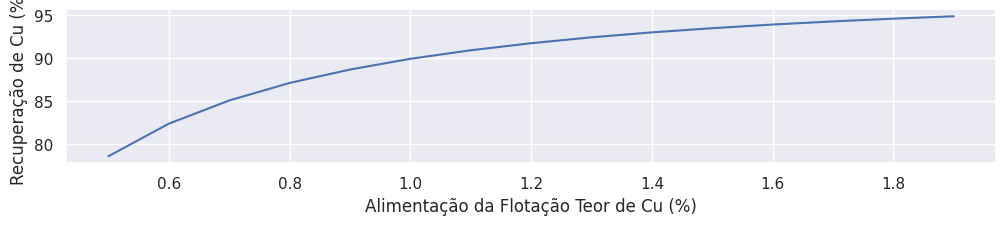

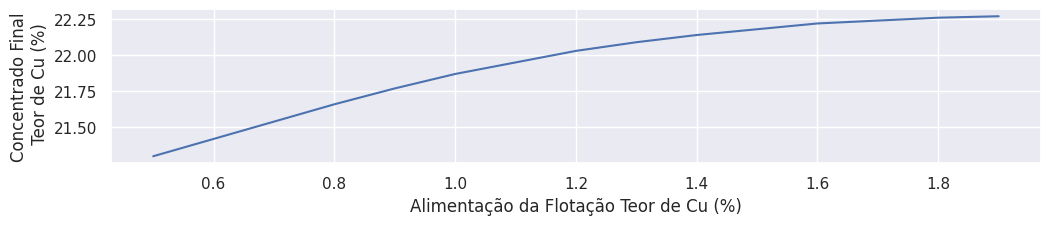

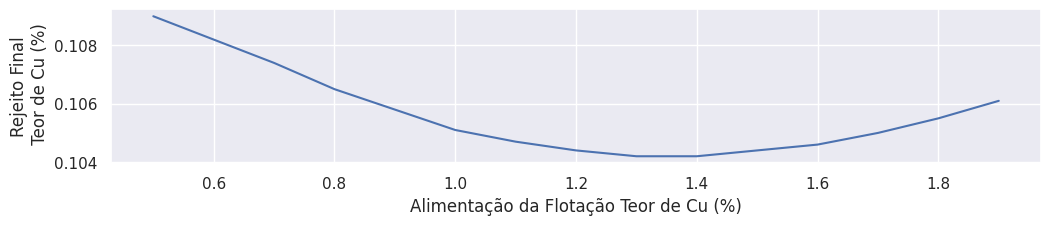

In [ ]:
# recovery = concentrate / feed * (feed - reject) / (concentrate - reject)

def get_recovery(feed, concentrate, reject):
    recovery = concentrate / feed * (feed - reject) / (concentrate - reject)

    return recovery

feed = np.asarray([0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])
concentrate = np.asarray([21.3, 21.42, 21.54, 21.66, 21.77, 21.87, 21.95, 22.03, 22.09, 22.14, 22.18, 22.22, 22.24, 22.26, 22.27])
reject = np.asarray([0.109, 0.1082, 0.1074, 0.1065, 0.1058, 0.1051, 0.1047, 0.1044, 0.1042, 0.1042, 0.1044, 0.1046, 0.105, 0.1055, 0.1061])

recovery = get_recovery(feed, concentrate, reject)

plt.figure(figsize=(12, 2))
plt.plot(feed, recovery*100)
plt.xlabel("Alimentação da Flotação Teor de Cu (%)")
plt.ylabel("Recuperação de Cu (%)")

plt.figure(figsize=(12, 2))
plt.plot(feed, concentrate)
plt.xlabel("Alimentação da Flotação Teor de Cu (%)")
plt.ylabel("Concentrado Final\n Teor de Cu (%)")

plt.figure(figsize=(12, 2))
plt.plot(feed, reject)
plt.xlabel("Alimentação da Flotação Teor de Cu (%)")
plt.ylabel("Rejeito Final\n Teor de Cu (%)")

### MVV Grinding

#### Data

In [ ]:
df = pd.read_csv('./datasets/mvv/mvv_grinding.csv', sep=";", decimal=',', parse_dates=["Timestamp"], infer_datetime_format=True).set_index('Timestamp').astype(float)
df.index = pd.to_datetime(df.index)
df.index = pd.to_datetime(pd.date_range(start=df.index[0], periods=df.shape[0], freq="5min").strftime("%Y-%m-%d %H:%M:%S.%f"))
df = df.resample("5min").interpolate(method="linear", limit_direction="both", axis=0)
df.index.name = "date_time"
# df.replace(0, np.nan, inplace=True)
df.interpolate(method="linear", limit_direction="both", axis=0)
df.fillna(method='ffill', axis=0, inplace=True)
# df = df.applymap(lambda x: 0 if x < 0 else x)

print(df.shape)

(15564, 10)


In [ ]:
# Z-score
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11496 entries, 2023-03-01 13:05:00 to 2023-04-24 14:00:00
Data columns (total 10 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   SystemArchive\ _2202_PP_001_ME1_II_FP.PV#Value           11496 non-null  float64
 1   SystemArchive\ _2202_PP_002_ME1_II_FP.PV#Value           11496 non-null  float64
 2   SystemArchive\ 2201-WT-001/2102-WT-001.PV#Value          11496 non-null  float64
 3   SystemArchive\ 2202-DIT-0001/2202-DIT-0001.PV#Value      11496 non-null  float64
 4   SystemArchive\ 2202-FIC-0003/2202-FIC-0003.PV#Value      11496 non-null  float64
 5   SystemArchive\ 2202-FIT-0002/2202-FIT-0002.PV#Value      11496 non-null  float64
 6   SystemArchive\ 2202-JT-0001/2202-JT-0001.PV#Value        11496 non-null  float64
 7   SystemArchive\ 2202-JT-0001/2202-JT-0002.PV#Value        11496 non-null  floa

In [ ]:
df.head()

SystemArchive\ _2202_PP_001_ME1_II_FP.PV#Value  \
date_time                                                             
2023-03-01 13:05:00                                            65.0   
2023-03-01 13:10:00                                            65.0   
2023-03-01 16:30:00                                            65.0   
2023-03-01 16:35:00                                            65.0   
2023-03-01 16:40:00                                            65.0   

                     SystemArchive\ _2202_PP_002_ME1_II_FP.PV#Value  \
date_time                                                             
2023-03-01 13:05:00                                             0.0   
2023-03-01 13:10:00                                             0.0   
2023-03-01 16:30:00                                             0.0   
2023-03-01 16:35:00                                             0.0   
2023-03-01 16:40:00                                             0.0   

                     SystemArchive\ 2201-WT-001/2102-WT-001.PV#Value  \
date_time                                                              
2023-03-01 13:05:00                                       525.990751   
2023-03-01 13:10:00                                       526.777757   
2023-03-01 16:30:00                                       532.738809   
2023-03-01 16:35:00                                       530.966951   
2023-03-01 16:40:00                                       521.125153   

                     SystemArchive\ 2202-DIT-0001/2202-DIT-0001.PV#Value  \
date_time                                                                  
2023-03-01 13:05:00                                           1.775844     
2023-03-01 13:10:00                                           1.782577     
2023-03-01 16:30:00                                           1.804875     
2023-03-01 16:35:00                                           1.806465     
2023-03-01 16:40:00                                           1.801543     

                     SystemArchive\ 2202-FIC-0003/2202-FIC-0003.PV#Value  \
date_time                                                                  
2023-03-01 13:05:00                                         121.136572     
2023-03-01 13:10:00                                         121.333669     
2023-03-01 16:30:00                                         150.287878     
2023-03-01 16:35:00                                         150.060235     
2023-03-01 16:40:00                                         149.960294     

                     SystemArchive\ 2202-FIT-0002/2202-FIT-0002.PV#Value  \
date_time                                                                  
2023-03-01 13:05:00                                         883.818524     
2023-03-01 13:10:00                                         871.202328     
2023-03-01 16:30:00                                         780.776242     
2023-03-01 16:35:00                                         798.568135     
2023-03-01 16:40:00                                         798.553699     

                     SystemArchive\ 2202-JT-0001/2202-JT-0001.PV#Value  \
date_time                                                                
2023-03-01 13:05:00                                          19.646027   
2023-03-01 13:10:00                                          19.575044   
2023-03-01 16:30:00                                          19.777210   
2023-03-01 16:35:00                                          19.775923   
2023-03-01 16:40:00                                          20.219655   

                     SystemArchive\ 2202-JT-0001/2202-JT-0002.PV#Value  \
date_time                                                                
2023-03-01 13:05:00                                        9809.910449   
2023-03-01 13:10:00                                        9799.675316   
2023-03-01 16:30:00                                        9991.013099   
2023-03-01 16:35:00             

In [ ]:
tags_cols = [
    '2202_PP_001_ME1_II_FP.PV', # Corrente Bomba Alimentação Ciclonagem/Célula Rougher
    '2202_PP_002_ME1_II_FP.PV', # Corrente Bomba Alimentação Ciclonagem/Célula Rougher
    '2102-WT-001.PV', # Balança Alimentação Moagem
    '2202-DIT-0001.PV', # Densidade Alimentação Ciclonagem
    '2202-FIC-0003.PV', # Controle Adição Água Moinho
    '2202-FIT-0002.PV', # Vazão Adição Água Tanque Moinho Bolas
    '2202-JT-0001.PV', # Potência Moinho de Bolas Dividido pela Alimentação
    '2202-JT-0002.PV', # Soma Potência dos 2 Motores Moinho Bolas 
    '2202-PIC-0101.PV', # Pressão Ciclonagem
    'P80_OV_CIC_L3.PV_In' # Granulometria Alimentação Rougher
]

columns = [
    '2202_PP_001_ME1_II_FP.PV',
    # '2202_PP_002_ME1_II_FP.PV',
    '2102-WT-001.PV',
    '2202-DIT-0001.PV',
    '2202-FIC-0003.PV',
    '2202-FIT-0002.PV',
    # '2202-JT-0001.PV',
    '2202-JT-0002.PV',
    '2202-PIC-0101.PV',
    'P80_OV_CIC_L3.PV_In'
]

input_columns = [
    '2202_PP_001_ME1_II_FP.PV',
    '2102-WT-001.PV',
    # '2202-DIT-0001.PV',
    '2202-FIC-0003.PV',
    '2202-FIT-0002.PV',    
    '2202-PIC-0101.PV',
]

output_columns = [
    '2202-DIT-0001.PV',
    '2202-JT-0002.PV',
    'P80_OV_CIC_L3.PV_In',
]

df.index.names = ["date_time"]
df.columns = tags_cols
df = df[columns]

df[input_columns + output_columns].to_csv("./datasets/mvv_grinding.csv")

<AxesSubplot: >

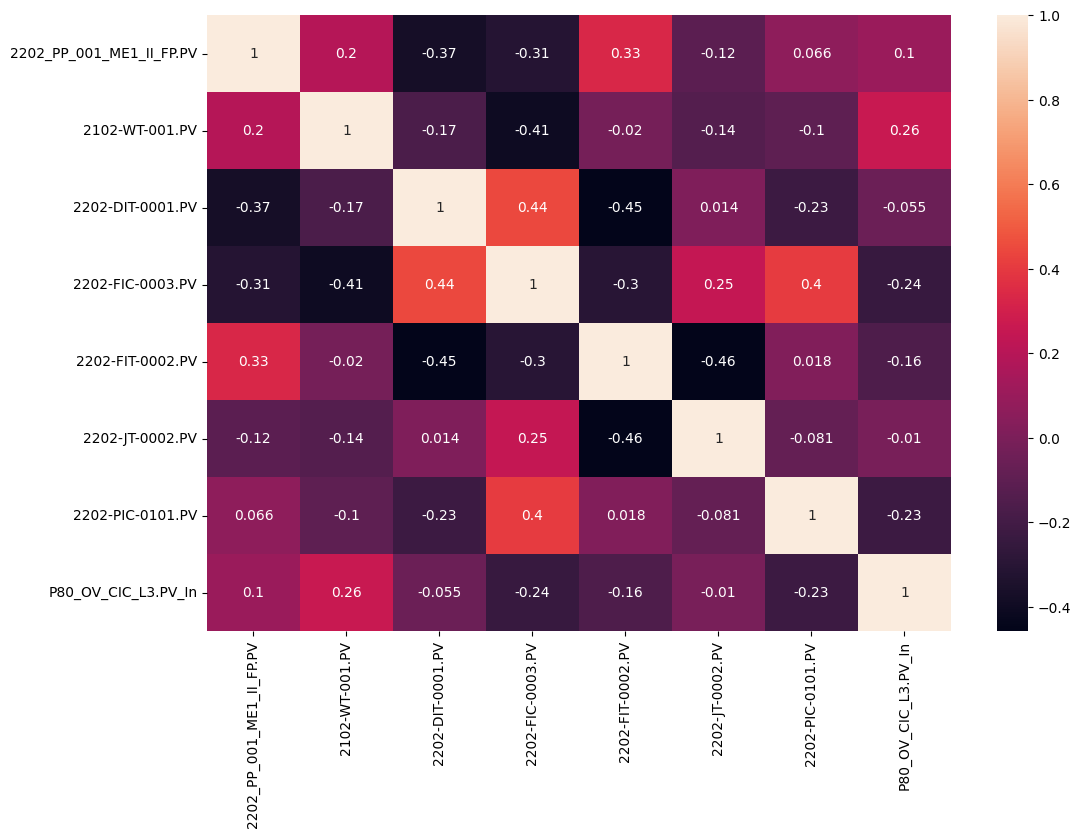

In [ ]:
df_corr = df.corr(method="pearson")

plt.figure(figsize=(12, 8))
sns.heatmap(df_corr, annot=True)

In [ ]:
df_corr[output_columns][df_corr[output_columns].abs() >= 0.2]

2202-DIT-0001.PV  2202-JT-0002.PV  \
2202_PP_001_ME1_II_FP.PV         -0.374696              NaN   
2102-WT-001.PV                         NaN              NaN   
2202-DIT-0001.PV                  1.000000              NaN   
2202-FIC-0003.PV                  0.443829         0.246440   
2202-FIT-0002.PV                 -0.452219        -0.457513   
2202-JT-0002.PV                        NaN         1.000000   
2202-PIC-0101.PV                 -0.229003              NaN   
P80_OV_CIC_L3.PV_In                    NaN              NaN   

                          P80_OV_CIC_L3.PV_In  
2202_PP_001_ME1_II_FP.PV                  NaN  
2102-WT-001.PV                       0.262486  
2202-DIT-0001.PV                          NaN  
2202-FIC-0003.PV                    -0.243894  
2202-FIT-0002.PV                          NaN  
2202-JT-0002.PV                           NaN  
2202-PIC-0101.PV                    -0.229374  
P80_OV_CIC_L3.PV_In                  1.000000

In [ ]:
input_size = len(input_columns)
output_size = len(output_columns)

x = df[input_columns].values
y = df[output_columns].values

In [ ]:
df[input_columns + output_columns].describe()

2202_PP_001_ME1_II_FP.PV  2102-WT-001.PV  2202-FIC-0003.PV  \
count              11496.000000    11496.000000      11496.000000   
mean                  65.339817      554.771170        113.247522   
std                    0.668764       11.795420         20.487723   
min                   63.916667      509.216655         60.557234   
25%                   65.000000      549.322469         99.855103   
50%                   65.000000      557.956662        100.589860   
75%                   66.000000      562.669874        129.480189   
max                   67.500000      590.978457        161.625575   

       2202-FIT-0002.PV  2202-PIC-0101.PV  2202-DIT-0001.PV  2202-JT-0002.PV  \
count      11496.000000      11496.000000      11496.000000     11496.000000   
mean         579.905787          0.842606          1.858774     10115.301424   
std          132.067546          0.067054          0.093288       125.456563   
min          185.167773          0.675016          1.517315      9672.091250   
25%          489.461072          0.795038          1.784556     10032.458819   
50%          564.917074          0.851331          1.858022     10124.546836   
75%          647.080882          0.898222          1.934674     10209.700222   
max          989.499500          1.015888          2.175831     10535.716813   

       P80_OV_CIC_L3.PV_In  
count         11496.000000  
mean            118.673243  
std              12.455209  
min              76.140312  
25%             111.426593  
50%             119.312008  
75%             126.911339  
max             154.685572

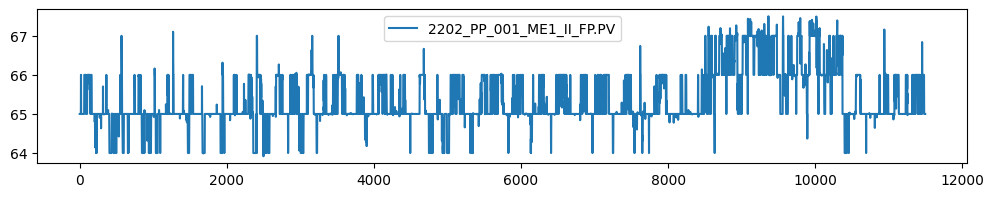

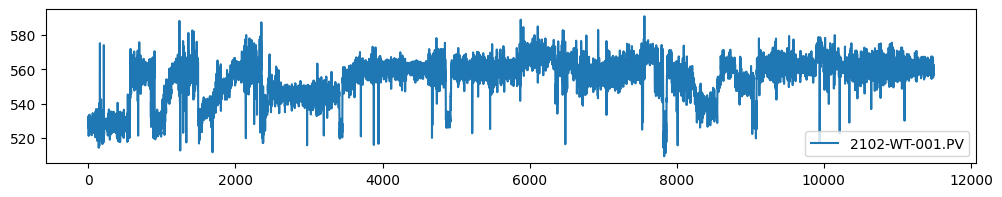

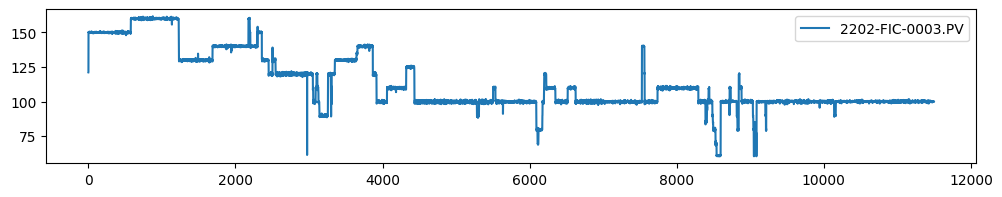

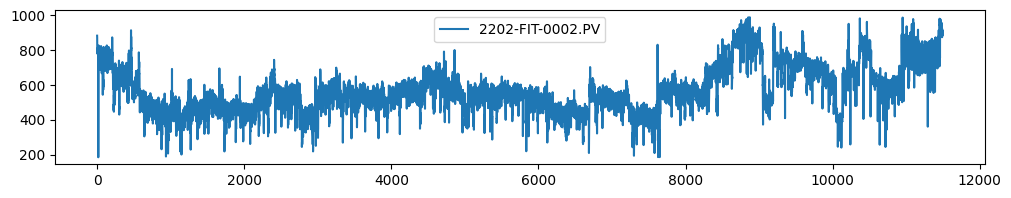

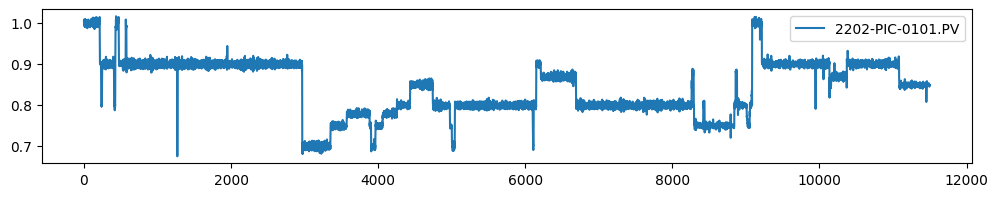

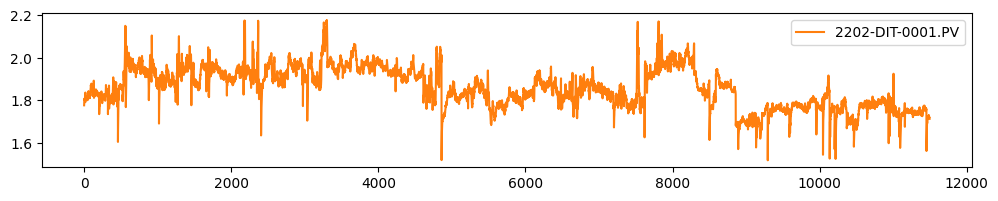

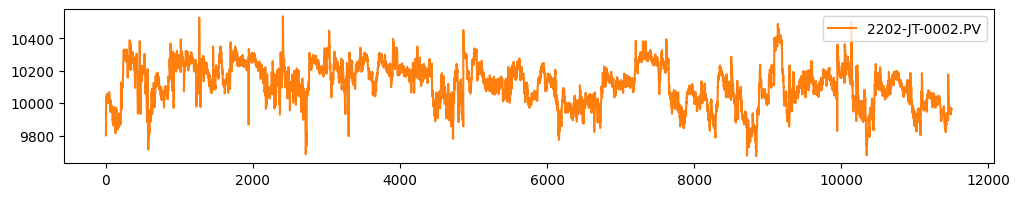

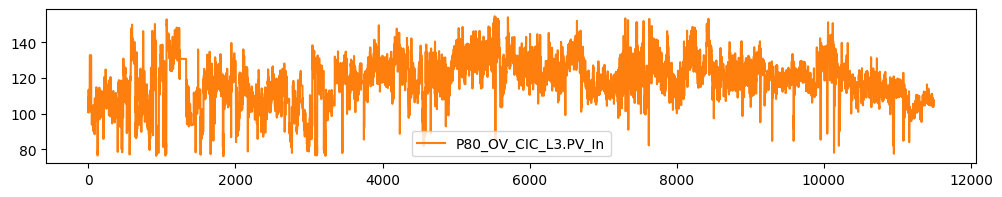

In [ ]:
for i in range(x.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(x[:, i], label=input_columns[i])
    plt.legend()
    plt.show()

for i in range(y.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(y[:, i], label=output_columns[i], color="tab:orange")
    plt.legend()
    plt.show()

In [ ]:
batch_size = 2**5
lag = 2**5

generator = Generator()
train_dataloader, val_dataloader = generator.generate_dataloaders(x, y, lag, batch_size)

#### Model

In [ ]:
config = {
    "input_size": input_size + output_size,
    "output_size": output_size,
    "hidden_size": 2**5,
    "num_layers": 2**1,
    "learning_rate": 1e-3,
    "dropout": 0.2,
    "lag": lag,
    "epochs": 2**6
}

In [ ]:
repeater = Repeater(**config).to(device)
print(repeater)

Repeater(
  (lstm): LSTM(8, 32, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=32, out_features=3, bias=True)
  (loss_fn): MSELoss()
)


#### Train

In [ ]:
%%time
repeater.fit(train_dataloader, val_dataloader)

Epoch 1/64
179/179 [====================================================================================================] 100%
0.0013s 0.0013s/step - train_loss: 0.03789705 - val_loss: 0.01625261 

Epoch 2/64
53/179 [==============================                                                                      ] 30%

179/179 [====================================================================================================] 100%
0.0027s 0.0014s/step - train_loss: 0.02772463 - val_loss: 0.01457724 

Epoch 3/64
179/179 [====================================================================================================] 100%
0.0041s 0.0014s/step - train_loss: 0.02344838 - val_loss: 0.01353820 

Epoch 4/64
179/179 [====================================================================================================] 100%
0.0055s 0.0014s/step - train_loss: 0.02094584 - val_loss: 0.01302205 

Epoch 5/64
179/179 [====================================================================================================] 100%
0.0070s 0.0014s/step - train_loss: 0.01926250 - val_loss: 0.01264483 

Epoch 6/64
179/179 [====================================================================================================] 100%
0.0085s 0.0014s/step - train_loss: 0.01805919 - val_loss: 0.01225514 

Epoch 7/64
179/179 [=

In [ ]:
model_path = './models/repeater_mvv_grinding.pt'
torch.save(repeater.state_dict(), model_path)

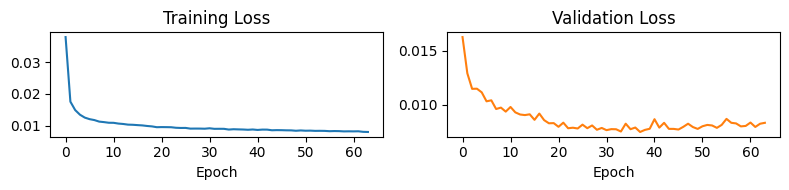

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].plot(repeater.train_loss)
axs[0].set_title('Training Loss')
axs[1].plot(repeater.val_loss, color='tab:orange')
axs[1].set_title('Validation Loss')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='')

fig.tight_layout()

#### Test

In [ ]:
for parameter in repeater.parameters():
  parameter.requires_grad = False
repeater.eval()

Repeater(
  (lstm): LSTM(8, 32, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=32, out_features=3, bias=True)
  (loss_fn): MSELoss()
)

In [ ]:
y_test_scaled = repeater.test(generator.x_test, (generator.x_val, generator.y_val))
y_test = generator.y_scaler.inverse_transform(y_test_scaled)

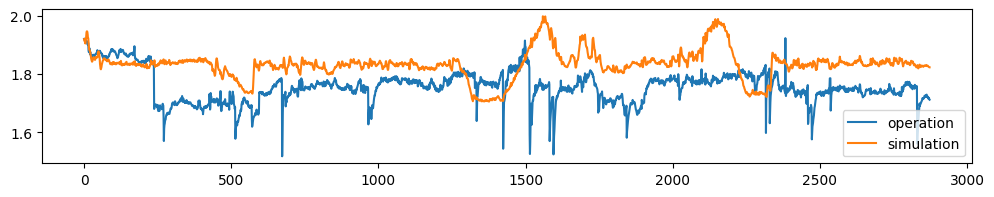

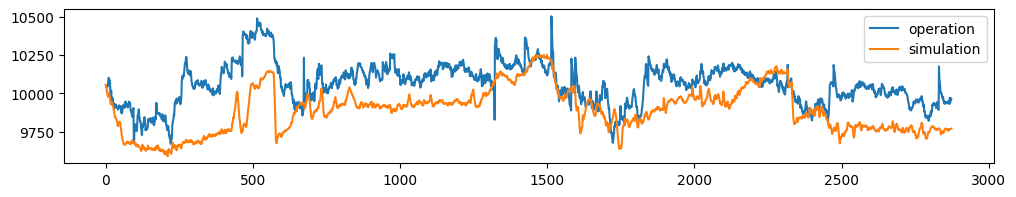

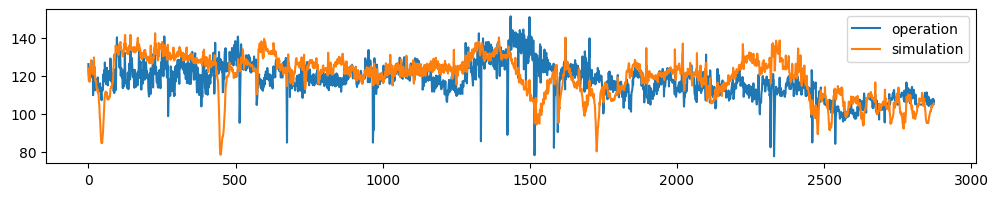

In [ ]:
for i in range(y.shape[1]):
    plt.figure(figsize=(12, 2))
    plt.plot(generator.y_scaler.inverse_transform(generator.y_test)[:, i], label='operation')
    plt.plot(y_test[:, i], label='simulation')
    plt.legend()
    plt.show()


#### Evaluate

In [ ]:
evaluator = Evaluator()

for i in range(output_size):
    metrics_dict = evaluator.measure(generator.y_scaler.inverse_transform(generator.y_test)[:, i], y_test[:, i])
    print(metrics_dict)

{'explained_variance_score': -0.6976938107658697, 'mean_absolute_error': 0.09026240808888426, 'mean_squared_error': 0.010815926848142242, 'root_mean_squared_error': 0.10399964830778151, 'median_absolute_error': 0.0842060923576341, 'mean_absolute_percentage_error': 0.05207400141696747, 'd2_absolute_error_score': -1.2678032207431067, 'd2_pinball_score': -1.2678032207431067, 'r2_score': -2.6908239984427333}
{'explained_variance_score': 0.13149321326347774, 'mean_absolute_error': 177.47131804236926, 'mean_squared_error': 43699.890468489575, 'root_mean_squared_error': 209.04518762336906, 'median_absolute_error': 174.32060221352458, 'mean_absolute_percentage_error': 0.01758957119332426, 'd2_absolute_error_score': -0.7147259698873845, 'd2_pinball_score': -0.7147259698873845, 'r2_score': -1.4655907456351813}
{'explained_variance_score': -0.4318640242091978, 'mean_absolute_error': 8.236221387376078, 'mean_squared_error': 117.99605729272311, 'root_mean_squared_error': 10.862599011872026, 'median

In [ ]:
evaluator = Evaluator()
metrics_dict = evaluator.measure(generator.y_scaler.inverse_transform(generator.y_test), y_test)
metrics_dict

{'explained_variance_score': -0.3326882072371958,
 'mean_absolute_error': 61.9326006126114,
 'mean_squared_error': 14605.965780569715,
 'root_mean_squared_error': 120.8551437902819,
 'median_absolute_error': 60.30043099535271,
 'mean_absolute_percentage_error': 0.04684323218781336,
 'd2_absolute_error_score': -0.7262491528371587,
 'd2_pinball_score': -0.7262491528371587,
 'r2_score': -1.5465998354123869}

In [ ]:
while True:
    time.sleep(1)
    pass

KeyboardInterrupt: 